This notebook is old, it contains some of the early model validation I was doing.

In [1]:
%load_ext autoreload
%autoreload 2

# Imports
import os
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import wandb
from torch.utils.data import DataLoader, Dataset
from omegaconf import OmegaConf
from pathlib import Path
from bachelors_thesis.modeling.siglabv2.siglabv2 import SigLabV2
from bachelors_thesis.modeling.siglabv2.siglab_deepsets import SigLabDeepsets
from bachelors_thesis.modeling.siglabv2.siglab_nocontext import SigLabNoContext
from bachelors_thesis.modeling.datasets.sigloc_dataset import SigLocDataset
from bachelors_thesis.evaluation import set_level_accuracy, lead_level_accuracy , pretty_code_density_plot
from bachelors_thesis.utils import plot_ecg, confusion_matrix, hungarian_predictions, apply_preprocessors, count_parameters, PRECORDIAL_LEAD_NAMES, LEAD_NAMES
from bachelors_thesis.data.ptbxl_utility import get_ecg_signals_from_file
from bachelors_thesis.data.preprocessing import median_filter, highpass
from bachelors_thesis.data.load_ptbdata_new import PRECORDIAL_LEADS, LIMB_LEADS, AUGMENTED_LEADS, ALL_LEADS
from bachelors_thesis.run import lead_sets
import seaborn as sns
import pandas as pd
import ast
from torchviz import make_dot
from IPython.display import Image
from collections import Counter
from scipy.ndimage import gaussian_filter1d

2025-05-25 10:49:57.982 | INFO     | bachelors_thesis.config:<module>:11 - PROJ_ROOT path is: C:\Users\natem\bachelors_thesis


In [4]:
project_path = "nateml-maastricht-university/bachelors-thesis"
#run_id = "4zf4bqsa"
#run_id = "z1tihobt"
#run_id = "38ndk83w"
#run_id = "hhn6gbli"
run_id = "oill5gwh"
#run_id = "yh0by5uj"
#artifact_name = "22_siglabv2_attn_rework"
#artifact_name = "36_siglabv2_simple_cnn_4"
#version = "v30"
version = "v23"
#artifact_name = "00_siglabv2_test"
device = "cuda" if torch.cuda.is_available() else "cpu"

In [5]:
# Load the torch model from wandb
api = wandb.Api()

run = api.run(f"{project_path}/{run_id}")
config = dict(run.config)

# Get the run name
run_name = run.name

artifact = api.artifact(f"{project_path}/{run_name}:{version}")
artifact_path = artifact.download()

# Convert config to omegaconf
cfg = OmegaConf.create(config)

# Load the model
checkpoint = torch.load(artifact_path + f"/{run_name}.pth", map_location=device)

# Cast the model to the correct type
model = SigLabV2(cfg.model).to(device)
model.load_state_dict(checkpoint)
model.eval()  # Put into evaluation mode

# Count number of parameters
print(f"Loaded model from wandb: {run_name}")
count_parameters(model)

wandb:   1 of 1 files downloaded.  


Loaded model from wandb: 93_siglabv2_simple_cnn
+----------------------------------------+------------+
|                Modules                 | Parameters |
+----------------------------------------+------------+
|        encoder.encoder.0.weight        |    544     |
|         encoder.encoder.0.bias         |     32     |
|        encoder.encoder.1.weight        |     32     |
|         encoder.encoder.1.bias         |     32     |
|        encoder.encoder.3.weight        |   22528    |
|         encoder.encoder.3.bias         |     64     |
|        encoder.encoder.4.weight        |     64     |
|         encoder.encoder.4.bias         |     64     |
|        encoder.encoder.6.weight        |   57344    |
|         encoder.encoder.6.bias         |    128     |
|        encoder.encoder.7.weight        |    128     |
|         encoder.encoder.7.bias         |    128     |
|        encoder.encoder.9.weight        |   163840   |
|         encoder.encoder.9.bias         |    256     |


(562764, 262144)

In [6]:
model

SigLabV2(
  (encoder): SimpleCNNEncoder(
    (encoder): Sequential(
      (0): Conv1d(1, 32, kernel_size=(17,), stride=(1,), padding=(8,))
      (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv1d(32, 64, kernel_size=(11,), stride=(1,), padding=(5,))
      (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
      (6): Conv1d(64, 128, kernel_size=(7,), stride=(1,), padding=(3,))
      (7): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): ReLU()
      (9): Conv1d(128, 256, kernel_size=(5,), stride=(1,), padding=(2,))
      (10): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (11): ReLU()
      (12): AdaptiveAvgPool1d(output_size=1)
      (13): Flatten(start_dim=1, end_dim=-1)
      (14): Dropout(p=0.1, inplace=False)
      (15): Linear(in_features=256, out_features=64, bias=True)
      (1

Loading the data

In [8]:
dataset_path = Path("../../" + cfg.dataset.path)
if OmegaConf.select(cfg, "dataset.only_precordial"):
    dataset_path = dataset_path / "precordial"
else:
    dataset_path = dataset_path / "all"
dataset_path = dataset_path.resolve()

val_data = np.load(dataset_path / "val.npy")
test_data = np.load(dataset_path / "test.npy")

# Apply preprocessors
val_data = apply_preprocessors(val_data,
                               cfg.dataset.sampling_rate,
                               cfg.preprocessor_group.preprocessors)
test_data = apply_preprocessors(test_data,
                                cfg.dataset.sampling_rate,
                                cfg.preprocessor_group.preprocessors)
#val_data = highpass(val_data, sampling_rate=100, low=0.5)
 
# Convert to torch tensor
val_data = torch.from_numpy(val_data).float().to(device)
val_data = val_data.permute(0, 2, 1)
print(val_data.shape)

test_data = torch.from_numpy(test_data).float().to(device)
test_data = test_data.permute(0, 2, 1)

# Create the dataset and dataloader
lead_filter = lead_sets[OmegaConf.select(cfg, "run.leads", default="precordial")]
dataset = SigLocDataset(test_data, filter_leads=lead_filter)
batch_size = 32
dataloader = DataLoader(dataset,
                        batch_size=batch_size,
                        shuffle=False)

print(dataset.label_order)
print(dataset.index_to_label)

# I need to reorder val_data to match the order of the labels in the dataset
#val_data = val_data[:, [ALL_LEADS.index(lead) for lead in lead_filter], :]
val_data = val_data[:, [PRECORDIAL_LEADS.index(lead) for lead in lead_filter], :]

# Load metadata
meta_val = pd.read_csv(dataset_path / "meta_val.csv")
meta_test = pd.read_csv(dataset_path / "meta_test.csv")
meta = meta_val.copy()
meta['scp_codes'] = meta['scp_codes'].apply(lambda x: ast.literal_eval(x))

THRESHOLD = 0.5
def codes_above_threshold(code_dict, thr=THRESHOLD):
    return {code for code, prob in code_dict.items() if prob >= thr}

meta["present_codes"] = meta["scp_codes"].apply(lambda x: codes_above_threshold(x, THRESHOLD))


torch.Size([2183, 6, 1000])
[0 1 2 3 4 5]
{0: 'V1', 1: 'V2', 2: 'V3', 3: 'V4', 4: 'V5', 5: 'V6'}


Forward pass through the model

In [9]:
c = cfg.model.num_classes
logits = np.zeros((len(dataset), c, c))
init_logits = np.zeros((len(dataset), c, c))
targets = np.zeros((len(dataset), c))

for idx, (signals, lead_labels) in enumerate(dataloader):
    signals = signals.to(device)
    lead_labels = lead_labels.to(device)

    if idx == 0:
        print(signals.shape)

    # Make predictions
    with torch.no_grad():
        these_logits = model(signals)
        logits[(idx * batch_size):(idx * batch_size + batch_size)] = these_logits.cpu().numpy()
        targets[(idx * batch_size):(idx * batch_size + batch_size)] = lead_labels.cpu().numpy()

print(logits.shape)

torch.Size([32, 6, 1000])
(2198, 6, 6)


Accuracy

In [10]:
#targets = torch.arange(c, device=logits[0].device).expand(logits.shape[0], -1)

if isinstance(logits, np.ndarray):
    logits = torch.from_numpy(logits).float()
if isinstance(init_logits, np.ndarray):
    init_logits = torch.from_numpy(init_logits).float()

probs = nn.functional.softmax(logits, dim=-1)

set_acc = set_level_accuracy(logits=logits.cpu().numpy(), targets=targets)
lead_acc = lead_level_accuracy(logits=logits.cpu().numpy(), targets=targets)
print(f"Set level accuracy: {set_acc:.4f}")
print(f"Lead level accuracy: {lead_acc:.4f}")

Set level accuracy: 0.9390
Lead level accuracy: 0.9788


In [11]:
# Precordial accuracy
precordial_labels = [lead_filter.index(lead) for lead in PRECORDIAL_LEAD_NAMES]
print(precordial_labels)
precord_logits = logits[:, precordial_labels, :]
precord_targets = targets[:, precordial_labels]
precord_set_acc = set_level_accuracy(logits=precord_logits.cpu().numpy(), targets=precord_targets)
precord_lead_acc = lead_level_accuracy(logits=precord_logits.cpu().numpy(), targets=precord_targets)
print(f"Precordial set level accuracy: {precord_set_acc:.4f}")
print(f"Precordial lead level accuracy: {precord_lead_acc:.4f}")

[0, 1, 2, 3, 4, 5]
Precordial set level accuracy: 0.9390
Precordial lead level accuracy: 0.9788


In [9]:
hungarian_preds = hungarian_predictions(logits.cpu().numpy())
hungarian_set_acc = set_level_accuracy(predictions=hungarian_preds, targets=targets)
hungarian_lead_acc = lead_level_accuracy(predictions=hungarian_preds, targets=targets)
print(f"Hungarian set level accuracy: {hungarian_set_acc:.4f}")
print(f"Hungarian lead level accuracy: {hungarian_lead_acc:.4f}")

Hungarian set level accuracy: 0.9542
Hungarian lead level accuracy: 0.9798


In [10]:
hungarian_preds.shape

(2183, 6)

# Find incorrect classifications

In [11]:
predictions = torch.argmax(logits, dim=-1).cpu().numpy()
mistake_mask = predictions != targets
mistake_counts = mistake_mask.sum(axis=1)
wrong = []
for i in range(1, 7):
    wrong.append(np.where(mistake_counts >= i)[0])

print(wrong[0])
print(len(wrong[0]))

[   9   23   34   35   36   52   78   83   92  110  166  185  198  215
  224  226  228  239  304  325  380  387  394  419  424  463  468  470
  471  483  486  524  538  567  578  632  669  673  683  686  689  717
  727  749  754  794  797  837  859  872  881  883  936  948  955  956
  961  966  999 1000 1004 1056 1058 1065 1067 1074 1077 1080 1198 1206
 1215 1218 1220 1240 1250 1290 1293 1296 1320 1379 1395 1407 1433 1459
 1468 1486 1495 1510 1511 1512 1546 1550 1595 1610 1614 1632 1647 1691
 1753 1754 1789 1808 1862 1911 2004 2011 2027 2041 2104 2176 2177]
111


slag med avvikande impulsutbredning supraventrikulÄr(a) extrasystoli(er) sinusrytm extrem vÄnster el-axel avvikande qrs(t) fÖrlopp    anterior myokardskada    inferior myokardskada


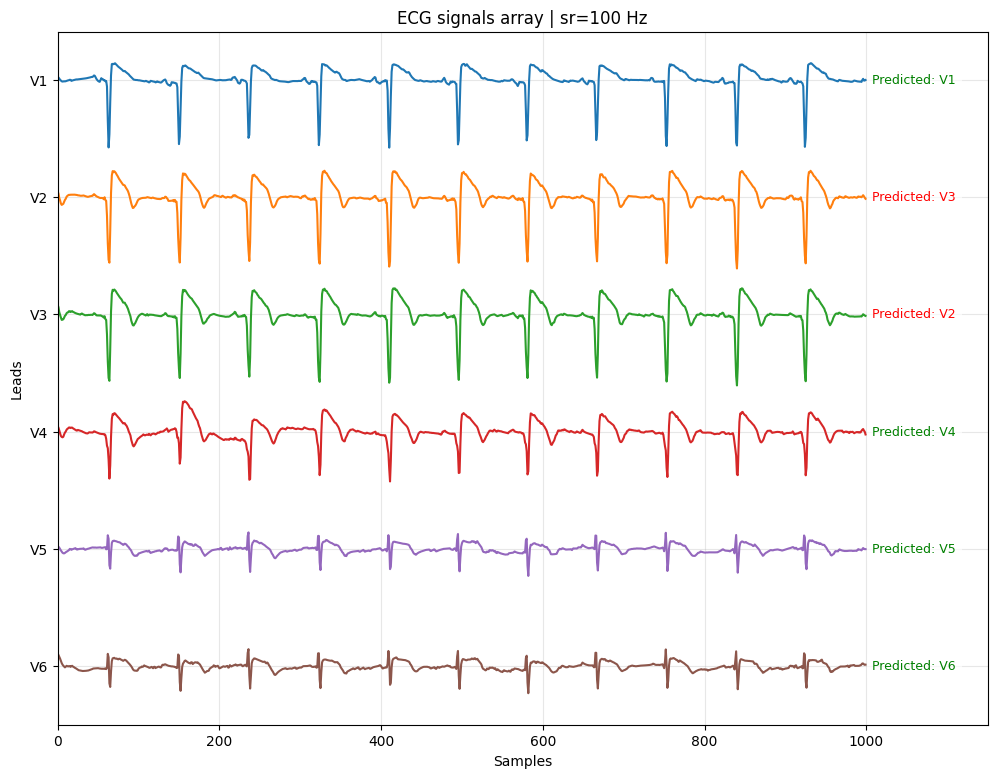

In [12]:
# Make background white
plt.style.use('default')
idx = wrong[0][3]
#idx = 0
signals = val_data[idx].cpu().numpy()
str_predictions = [lead_filter[p] for p in predictions[idx]]
plot_ecg(signals, sampling_rate=cfg.dataset.sampling_rate, predictions=str_predictions, leads=lead_filter)
print(meta.iloc[idx].report)

In [13]:
for dis in probs[idx]:
    dis_np = dis.cpu().numpy()
    for p in dis_np:
        print(f"{p:.4f}", end=" ")
    print()

0.9998 0.0002 0.0001 0.0000 0.0000 0.0000 
0.0001 0.3241 0.6757 0.0001 0.0000 0.0000 
0.0002 0.9199 0.0799 0.0000 0.0000 0.0000 
0.0000 0.0000 0.0006 0.9991 0.0003 0.0001 
0.0000 0.0000 0.0000 0.0003 0.9940 0.0057 
0.0000 0.0000 0.0000 0.0002 0.0061 0.9937 


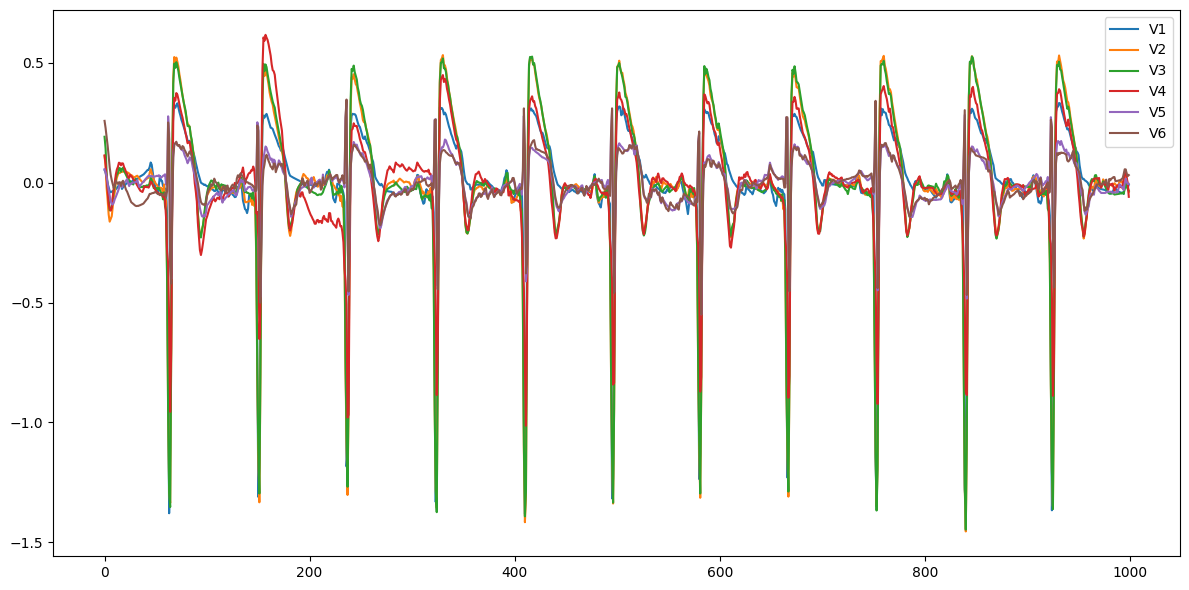

In [15]:
from matplotlib import pyplot as plt
# Overlay all the leads
plt.figure(figsize=(12, 6))
for i, lead in enumerate(lead_filter):
    plt.plot(signals[i], label=lead)

plt.legend()

plt.tight_layout()
plt.show()

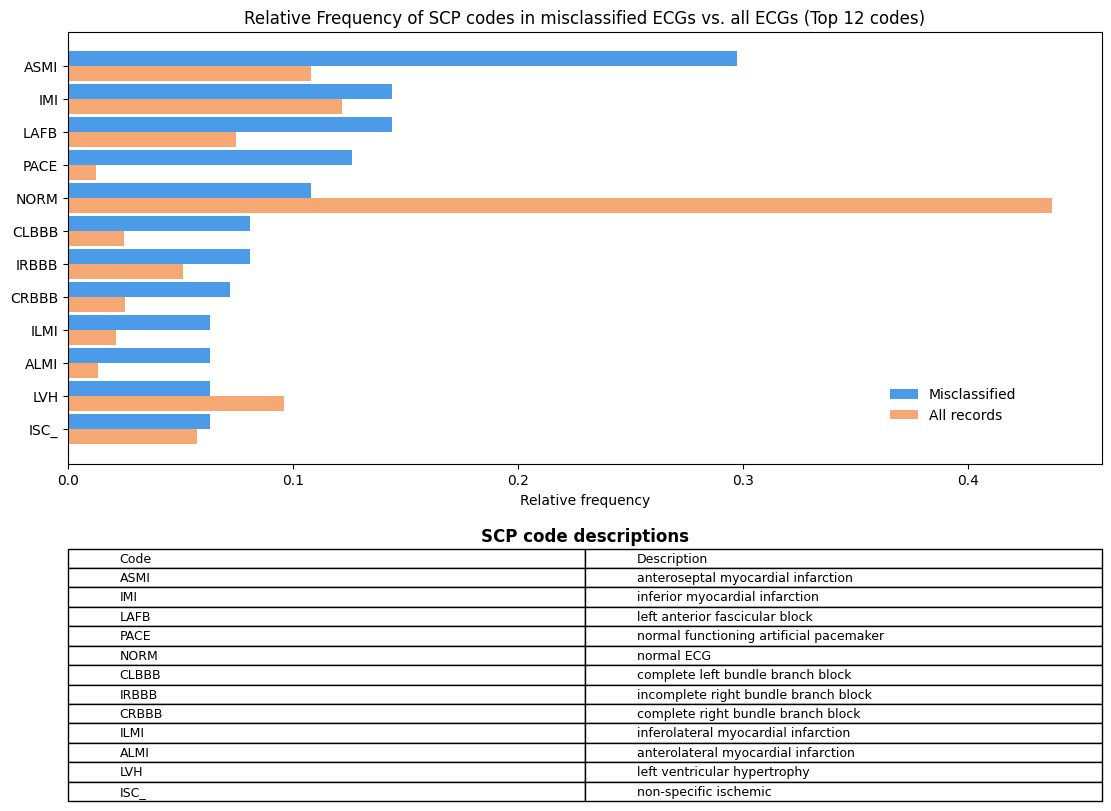

In [16]:
distribution = Counter(code
                       for codes in meta["present_codes"]
                       for code in codes)

outlier_distribution = Counter(code
                                for codes in meta.iloc[wrong[0]]["present_codes"]
                                for code in codes)

pretty_code_density_plot(
    distribution,
    outlier_distribution,
    n = 12,
    n_misclassified=len(wrong[0]),
    n_total=len(meta),
    relative=True,
    scp_statement_csv='../../data/raw/ptb-xl/scp_statements.csv',
)

In [17]:
# Calculate accuracy on pacemaker samples
pacemaker_idx = np.where(meta["present_codes"].apply(lambda x: "PACE" in x))[0]
print(len(pacemaker_idx))

pacemaker_acc = set_level_accuracy(predictions=predictions[pacemaker_idx])
pacemaker_acc

27


np.float64(0.48148148148148145)

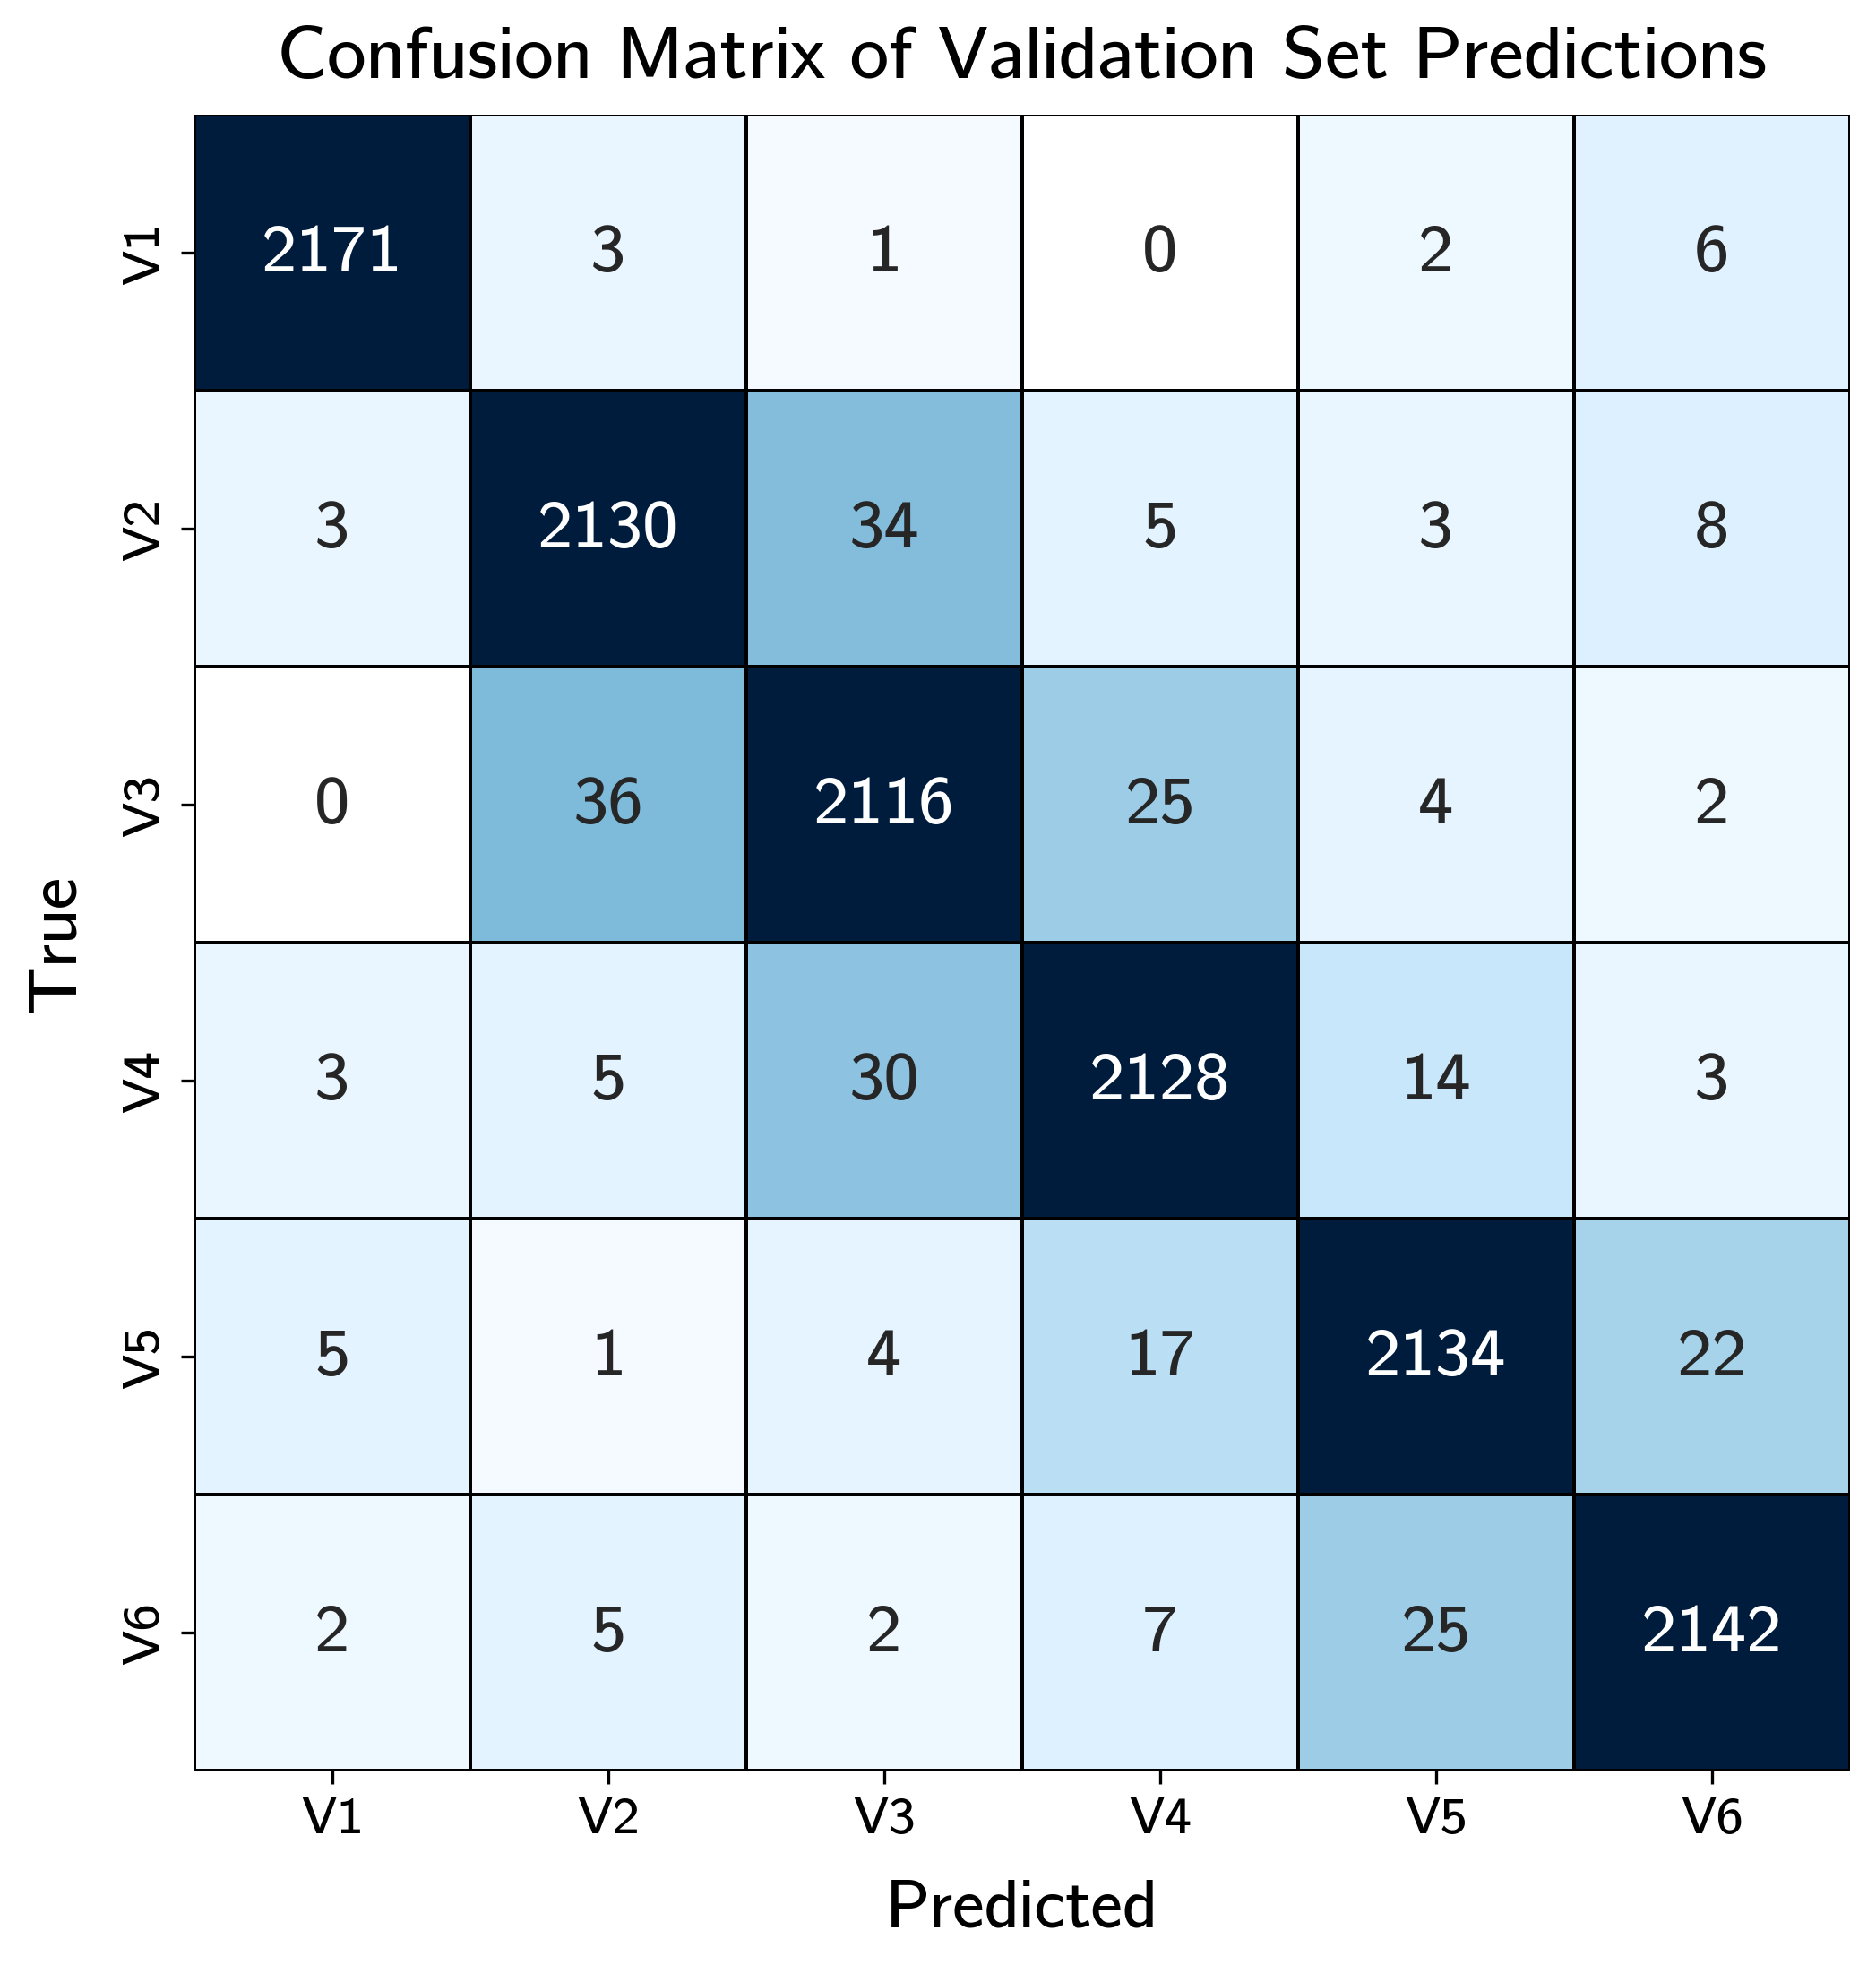

In [18]:
# Confusion matrix
from matplotlib.colors import LinearSegmentedColormap

dark_blue = "#001C3D"

um_cmap = LinearSegmentedColormap.from_list(
    "um_blues", ['#ffffff', '#d6eeff', '#0070A3', dark_blue], N=256
)

plt.rcParams.update({
    "font.family":  "serif",              # or "sans-serif" if you prefer CMU Bright
    "font.serif":   ["CMU Bright"],       # fallback to CMR if Bright missing
    "axes.labelsize": 12,
    "axes.titlesize": 16,
    "xtick.labelsize": 14,
    "ytick.labelsize": 14,
    "font.weight": "semibold",
    "mathtext.fontset": "cm",
    "axes.titlepad": 10,
    "axes.labelpad": 10,
})

cm = confusion_matrix(predictions, targets)
cm_log = np.log(cm + 1)

# Plot the confusion matrix
plt.figure(figsize=(8, 8), dpi=300)
sns.heatmap(cm_log, annot=cm, fmt="d", cmap=um_cmap, cbar=False, square=True,
            xticklabels=PRECORDIAL_LEAD_NAMES, yticklabels=PRECORDIAL_LEAD_NAMES,
            annot_kws={"size": 18, "weight": "bold"}, linecolor="black", linewidths=0.5)
plt.title("Confusion Matrix of Validation Set Predictions", fontsize=20, weight="bold")
plt.xlabel("Predicted", fontsize=18, weight="bold")
plt.ylabel("True", fontsize=18, weight="bold")


# Save the figure
plt.savefig(f"../reports/figures/confusion_matrix_{run_id}.png", dpi=600, bbox_inches="tight")

plt.show()    

In [19]:
from matplotlib.colors import LinearSegmentedColormap

# Define the Maastricht University blue and yellow colors for the theme
MAASTRICHT_BLUE = "#1D4E89"  # Maastricht University blue
MAASTRICHT_YELLOW = "#FFD700"  # Maastricht University yellow

light_blue = "#00A2DB"

# Adjust font properties
#plt.rcParams['axes.labelsize'] = 14
#plt.rcParams['axes.titlesize'] = 16
#plt.rcParams['xtick.labelsize'] = 12
#plt.rcParams['ytick.labelsize'] = 12
#plt.rcParams['font.weight'] = 'semibold'
#plt.rcParams['font.family'] = 'serif'
#plt.rcParams.update({ "font.family": "serif", "font.serif": ["CMU Bright"], "mathtext.fontset": "cm"}) # for math symbols })
# ── 1.  Global style to match earlier figures ──────────────────────
plt.rcParams.update({
    "font.family":  "serif",              # or "sans-serif" if you prefer CMU Bright
    "font.serif":   ["CMU Bright"],       # fallback to CMR if Bright missing
    "axes.labelsize": 12,
    "axes.titlesize": 16,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "font.weight": "semibold",
    "mathtext.fontset": "cm",
    "axes.titlepad": 10,
})

# Visualize the confusion matrices with Maastricht University theme
plt.figure(figsize=(12, 9), dpi=600)

conf_mats = [
    ("Normal",                 cm_norm,        cm_norm_log),
    ("Myocardial Infarction",  cm_mi,          cm_mi_log),
    ("ST-T Change",            cm_sttc,        cm_sttc_log),
    ("Conduction Disturbance", cm_cd,          cm_cd_log),
    ("Hypertrophy",            cm_hypertrophy,         cm_hypertrophy_log),
]

for i, (title, cm_raw, cm_log) in enumerate(conf_mats, start=1):
    plt.subplot(2, 5, i)
    sns.heatmap(cm_log, annot=cm_raw, fmt="d", cmap=um_cmap, cbar=False, square=True,
                xticklabels=PRECORDIAL_LEAD_NAMES, yticklabels=PRECORDIAL_LEAD_NAMES,
                annot_kws={"size": 10, 'weight': 'bold'}, linewidths=0.5, linecolor='black')
    plt.title(title, fontsize=14, fontweight='bold')
    if i == 1:
        plt.ylabel("True", fontsize=12, fontweight='semibold')
    plt.xlabel("Predicted", fontsize=12, fontweight='semibold')

# Save the figure
plt.savefig("../reports/figures/confusion_matrices.png", dpi=600, bbox_inches='tight')

plt.tight_layout()
plt.show()

NameError: name 'cm_norm' is not defined

<Figure size 7200x5400 with 0 Axes>

In [111]:
# Calculate accuracy and precision for each lead
cm = confusion_matrix(predictions, targets)

# acc, precision, recall
precision = []
recall = []

for lead in range(cm.shape[0]):
    tp = cm[lead, lead]
    fp = cm[:, lead].sum() - tp
    fn = cm[lead, :].sum() - tp

    precision.append(tp / (tp + fp) if (tp + fp) > 0 else 0)
    recall.append(tp / (tp + fn) if (tp + fn) > 0 else 0)

# Create a DataFrame for better visualization
df = pd.DataFrame({
    "Lead": PRECORDIAL_LEAD_NAMES,
    "Precision": precision,
    "Recall": recall
})

# Sort the DataFrame by accuracy
df = df.sort_values(by="Precision", ascending=False)

# Print the DataFrame in a readable format so that the values are formatted to 4 decimal places
pd.set_option('display.float_format', '{:.4f}'.format)
print(df.to_string(index=False))

Lead  Precision  Recall
  V1     0.9941  0.9950
  V6     0.9803  0.9812
  V5     0.9776  0.9776
  V4     0.9771  0.9762
  V2     0.9753  0.9762
  V3     0.9702  0.9684


In [21]:
# Calculate acc on all diagnostic superclasses
acc_norm = cm_norm.diagonal().sum() / cm_norm.sum()
acc_mi = cm_mi.diagonal().sum() / cm_mi.sum()
acc_sttc = cm_sttc.diagonal().sum() / cm_sttc.sum()
acc_cd = cm_cd.diagonal().sum() / cm_cd.sum()
acc_hypertrophy = cm_hypertrophy.diagonal().sum() / cm_hypertrophy.sum()
print(f"Normal: {acc_norm:.4f}")
print(f"Myocardial Infarction: {acc_mi:.4f}")
print(f"ST/T change: {acc_sttc:.4f}")
print(f"Conduction disturbance: {acc_cd:.4f}")
print(f"Hypertrophy: {acc_hypertrophy:.4f}")

Normal: 0.9960
Myocardial Infarction: 0.9586
ST/T change: 0.9804
Conduction disturbance: 0.9572
Hypertrophy: 0.9869


## What happens when we limit the leads we give the model?

In [22]:
sample = wrong[0][0]
#sample = pacemaker_idx[2]
#sample = 1
#sample = 0
sample = 3
time_window = (0, 1000)
print(sample)
print(meta.iloc[sample].report)
print(meta.iloc[sample].diagnostic_superclass)
print(meta.iloc[sample].scp_codes)

3
vorhofflattern 2:1 Überleitung,jetzt nach isoptin 2amp+ 1 amp digitalis teilweise 3:1 .vorhof:ca. hf:265 linkstyp st-senkung ii  iii avf  v4-v6  bei tachycardie
[]
{'AFLT': 100.0}


In [23]:
# print the predictions
print("Predictions: ", [lead_filter[p] for p in predictions[sample]])

Predictions:  ['V1', 'V2', 'V3', 'V4', 'V5', 'V6']


In [24]:
test_x = val_data[0]
test_x = test_x[[1, 2, 0, 3, 5, 4]]
# add a batch dimension
test_x = test_x.unsqueeze(0)
print(test_x.shape)
logits = model(test_x)

torch.Size([1, 6, 1000])


0.0002 0.9998 0.0000 0.0000 0.0000 0.0000 
0.0000 0.0001 0.9996 0.0003 0.0000 0.0000 
0.9993 0.0005 0.0002 0.0000 0.0000 0.0000 
0.0000 0.0000 0.0002 0.9986 0.0009 0.0002 
0.0000 0.0000 0.0000 0.0001 0.0024 0.9975 
0.0000 0.0000 0.0000 0.0007 0.9971 0.0022 


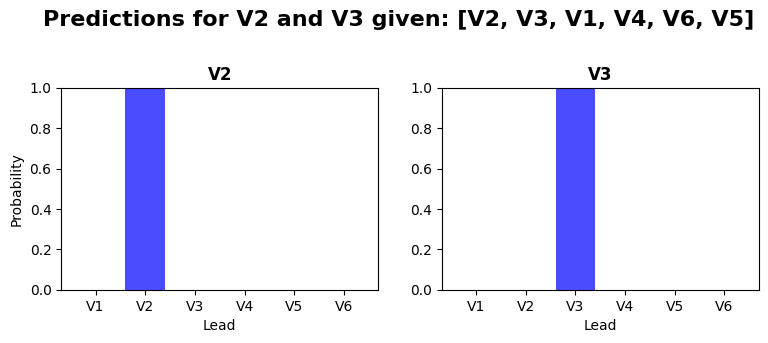

In [25]:
# Change to white background
plt.style.use('default')

probs = torch.softmax(logits, dim=-1)
probs = probs.detach().cpu().numpy()
for i in range(probs.shape[1]):
    for j in range(probs.shape[2]):
        print(f"{probs[0][i][j]:.4f}", end=" ")
    print()

# Plot probability distributions as bar charts
plt.figure(figsize=(9, 6))
names = ['V2', 'V3']

for i in range(2):
    plt.subplot(2, 2, i + 1)
    plt.bar(['V1', 'V2', 'V3', 'V4', 'V5', 'V6'], probs[0][i], color='blue', alpha=0.7)
    plt.title(names[i], fontweight="bold")
    plt.xlabel("Lead")
    if i == 0:
        plt.ylabel("Probability")
    #plt.xticks(range(len(LEAD_NAMES)), LEAD_NAMES, rotation=90)
    plt.ylim(0, 1)

plt.suptitle("Predictions for V2 and V3 given: [V2, V3, V1, V4, V6, V5]", fontsize=16, fontweight="bold")
plt.subplots_adjust(top=0.85)
plt.show()

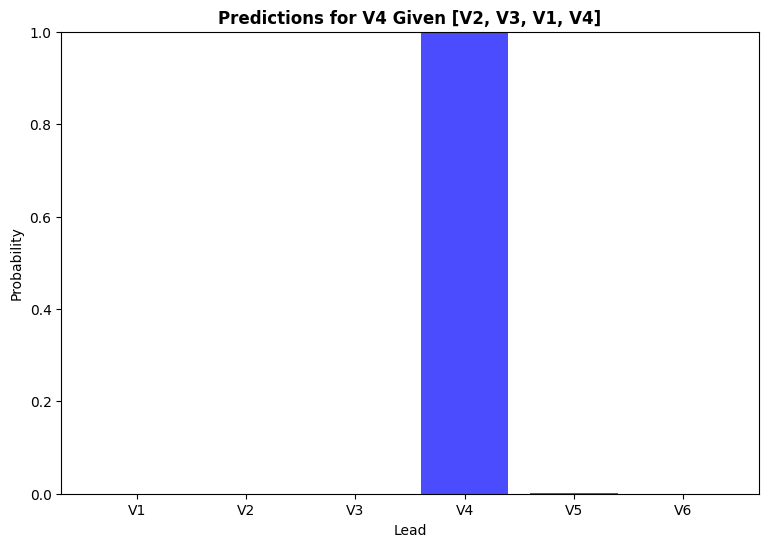

In [26]:
# Show the probability distribution for the last lead
plt.figure(figsize=(9, 6))
plt.subplot(1, 1, 1)
plt.bar(['V1', 'V2', 'V3', 'V4', 'V5', 'V6'], probs[0][3], color='blue', alpha=0.7)
plt.title("Predictions for V4 Given [V2, V3, V1, V4]", fontweight="bold")
plt.xlabel("Lead")
plt.ylabel("Probability")
plt.ylim(0, 1)
plt.show()


## Saliency
Where does the model "look"?

<Axes: title={'center': 'ECG signals array | sr=100 Hz'}, xlabel='Samples', ylabel='Leads'>

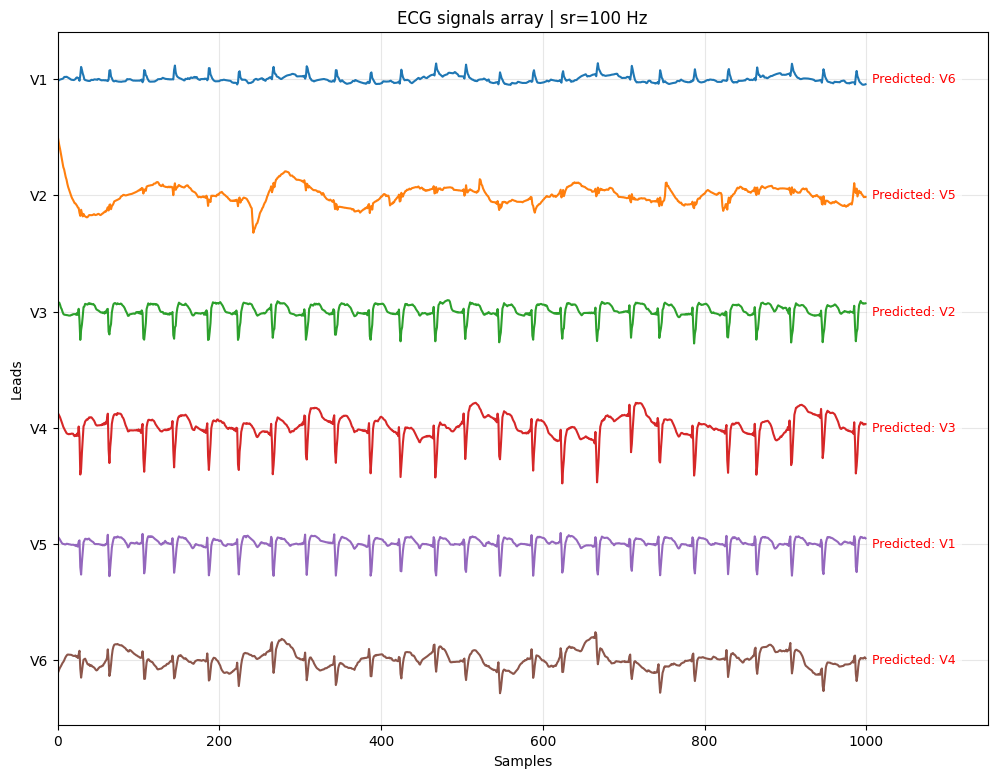

In [35]:
signals = val_data[sample].cpu().numpy()
plot_ecg(signals, sampling_rate=cfg.dataset.sampling_rate, predictions=[lead_filter[p] for p in predictions[sample]], leads=lead_filter)

In [53]:
from bachelors_thesis.data.preprocessing import highpass
# Pass the signal through the preprocessor
highpass_signal = highpass(signals, sampling_rate=100, low=0.5)


<Axes: title={'center': 'ECG signals array | sr=100 Hz'}, xlabel='Samples', ylabel='Leads'>

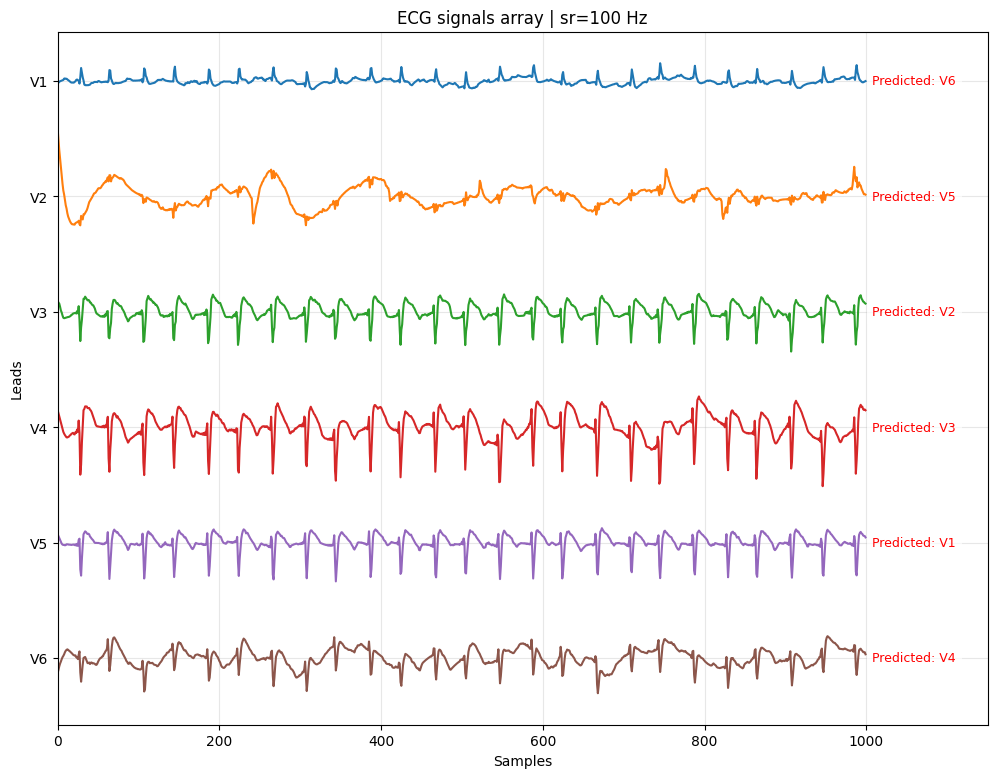

In [54]:
plot_ecg(highpass_signal, sampling_rate=cfg.dataset.sampling_rate, predictions=[lead_filter[p] for p in predictions[sample]], leads=lead_filter)

<Axes: title={'center': 'ECG signals array | sr=100 Hz'}, xlabel='Samples', ylabel='Leads'>

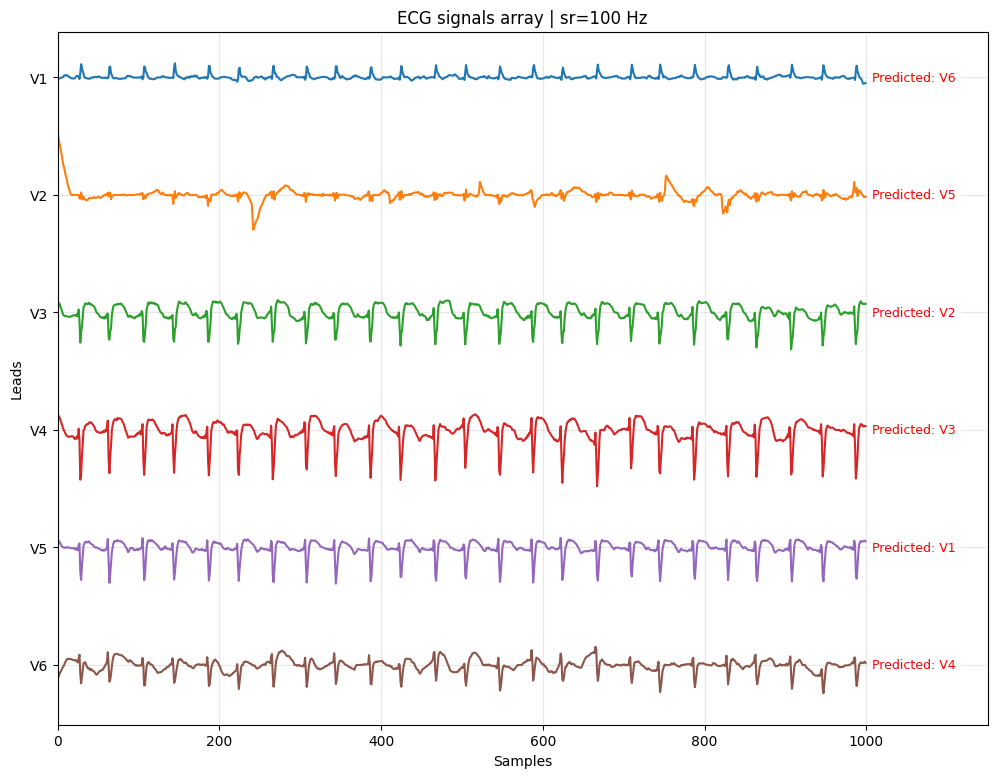

In [76]:
from bachelors_thesis.data.preprocessing import median_filter
median_filtered_signal = median_filter(signals, sampling_rate=100)
plot_ecg(median_filtered_signal, sampling_rate=cfg.dataset.sampling_rate, predictions=[lead_filter[p] for p in predictions[sample]], leads=lead_filter)

In [63]:
torch.from_numpy(median_filtered_signal).to(device).unsqueeze(0).shape

torch.Size([1, 6, 1000])

387


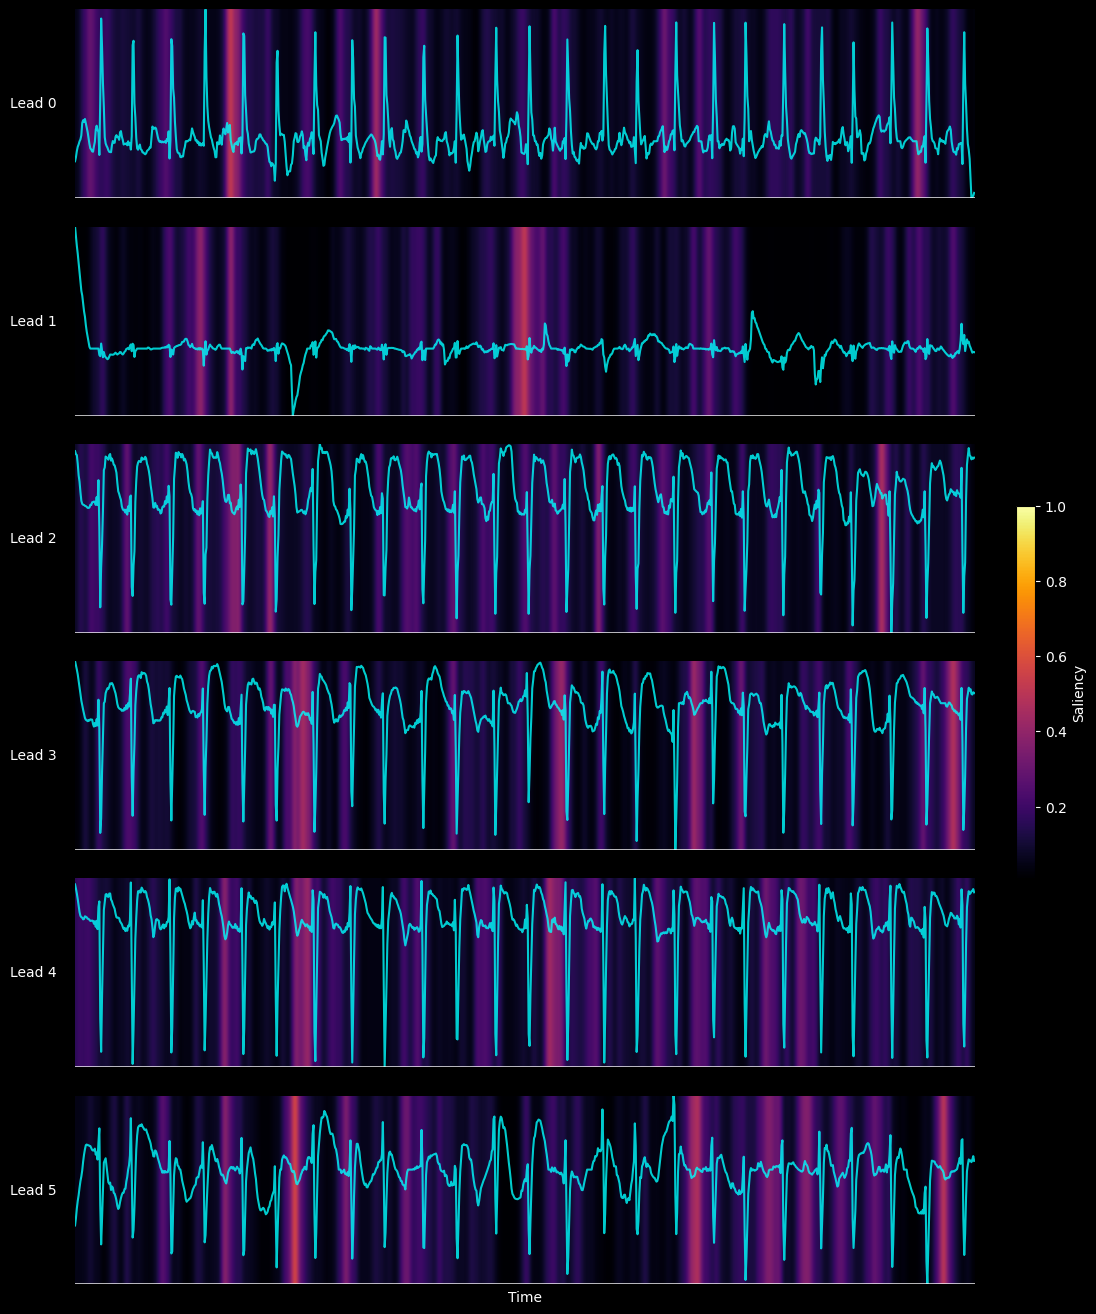

In [77]:
sample = wrong[3][2]
print(sample)

lead_indices = [0, 1, 2, 3, 4, 5]  # define the leads you want to visualize

#x = val_data[sample].unsqueeze(0)  # shape [1, L, T]
x = torch.from_numpy(median_filtered_signal).to(device).unsqueeze(0)  # shape [1, L, T]
x.requires_grad = True
x.to(device)

# put the model in train mode to get gradients
model.train()

# Get output and select the classification head output
output = model(x)[0]  # [num_leads, num_classes]

# Create subplots
num_leads = len(lead_indices)
fig, axes = plt.subplots(num_leads, 1, figsize=(12, 2.5 * num_leads), sharex=True,
                         gridspec_kw={'hspace': 0.15})

for i, lead in enumerate(lead_indices):
    lead_output = output[lead]
    target_idx = lead_output.argmax()
    target = lead_output[target_idx]

    model.zero_grad()
    x.grad = None
    target.backward(retain_graph=True)

    saliency = x.grad.data.abs()[0, lead].cpu().numpy()
    saliency = saliency / saliency.max()
    saliency = saliency[time_window[0]:time_window[1]]
    saliency_smooth = gaussian_filter1d(saliency, sigma=3)
    saliency_2d = saliency_smooth[np.newaxis, :]

    ecg = x[0, lead].cpu().detach().numpy()
    ecg = ecg[time_window[0]:time_window[1]]
    ecg_scaled = (ecg - ecg.min()) / (ecg.max() - ecg.min())

    ax = axes[i] if num_leads > 1 else axes
    im = ax.imshow(saliency_2d,
                   cmap='inferno',
                   aspect='auto',
                   extent=[0, len(ecg), 0, 1],
                   norm=plt.Normalize(vmin=0.01, vmax=saliency.max()))

    ax.plot(np.arange(len(ecg)), ecg_scaled, color='cyan', linewidth=1.5, linestyle='-', alpha=0.8)

    # Minimal labeling
    ax.set_yticks([])
    ax.set_ylabel(f"Lead {lead}", color='white', rotation=0, labelpad=30, fontsize=10, va='center')
    ax.set_facecolor('black')
    ax.tick_params(colors='white')
    ax.axhline(y=0, color='white', linewidth=2, alpha=0.8)

    # Clean borders
    for spine in ax.spines.values():
        spine.set_visible(False)

    # Hide x-ticks on all but last subplot
    if i < num_leads - 1:
        ax.set_xticks([])
    else:
        ax.set_xlabel('Time', color='white')

# Add a single colorbar to the side
cbar = fig.colorbar(im, ax=axes, orientation='vertical', fraction=0.02, pad=0.01)
cbar.set_label('Saliency', color='white')
cbar.ax.yaxis.set_tick_params(color='white')
plt.setp(cbar.ax.get_yticklabels(), color='white')

# Title for the whole figure
#fig.suptitle(f'Saliency maps for sample {sample}', color='white', fontsize=18)
fig.patch.set_facecolor('black')

#plt.tight_layout(rect=[0, 0, 0.97, 0.90])
plt.subplots_adjust(left=0.1, right=0.85, top=0.95, bottom=0.1)
plt.show()

In [78]:
torch.softmax(logits, dim=-1)

tensor([[[1.7173e-04, 9.9978e-01, 4.9613e-05, 2.1279e-06, 9.0207e-09,
          2.0663e-08],
         [1.9917e-05, 9.6391e-05, 9.9957e-01, 3.1409e-04, 9.7949e-07,
          6.6624e-07],
         [9.9933e-01, 4.7769e-04, 1.8921e-04, 1.5723e-06, 9.1466e-08,
          5.3961e-07],
         [1.5110e-06, 2.5186e-06, 2.4563e-04, 9.9864e-01, 9.3965e-04,
          1.7427e-04],
         [6.3493e-08, 8.9008e-08, 1.3300e-06, 1.4876e-04, 2.3969e-03,
          9.9745e-01],
         [2.6367e-08, 1.2505e-07, 8.9179e-06, 6.9402e-04, 9.9713e-01,
          2.1640e-03]]], device='cuda:0', grad_fn=<SoftmaxBackward0>)

In [76]:
# I am going to align all the beats
import neurokit2 as nk
import torch
import torch.nn.functional as F
from tqdm import tqdm

# Turn off warnings
import warnings
#warnings.filterwarnings("ignore", category=UserWarning, module="neurokit2")
#warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")
warnings.filterwarnings("ignore", category=UserWarning)

def compute_saliency(model, x):
    """
    Compute the saliency map for a given input x.
    x: (B, L, T)
    """
    saliency = np.zeros(x.shape)

    for i in tqdm(range(x.shape[0])):
        for lead in range(x.shape[1]):
            x_ = x[i].unsqueeze(0)  # shape [1, L, T]
            x_.requires_grad = True
            output = model(x_)[0][lead]  # [num_leads, num_classes]
            target_idx = output.argmax()
            target = output[target_idx]

            model.zero_grad()
            x_.grad = None
            target.backward(retain_graph=True)

            saliency[i][lead] = x_.grad.data.abs()[0, lead].abs().cpu().numpy()

    return saliency

def get_all_beats(ecg_signal, fs=100):
    """
    Parameters
    ----------
    ecg_signal : (T,) numpy array – single lead
    fs         : sampling freq in Hz
    
    Returns
    -------
    beats : list of (start_idx, end_idx, r_idx)
        indices in *original* signal
    """
    # 1. R-peaks
    _, rpeaks = nk.ecg_peaks(ecg_signal, sampling_rate=fs)
    r_locs = rpeaks["ECG_R_Peaks"]          # 1-D array of sample indices

    # 2. Choose a window: e.g. −0.35 s … +0.45 s  ⇒ fits most RR intervals < 120 bpm
    pre  = int(0.35 * fs)
    post = int(0.45 * fs)

    beats = []
    for r in r_locs:
        start, end = r - pre, r + post
        if start < 0 or end >= len(ecg_signal):
            continue                        # skip incomplete beats
        beats.append((start, end, r))
    return beats

def slice_and_warp(x, sal, beats, target_len=1000):
    """
    x    : (L, T)   raw ECG (L leads)
    sal  : (L, T)   saliency already aligned with x
    beats: list from get_all_beats
    """

    Xbeats, Salbeats = [], []
    for s, e, _ in beats:
        seg_x   = x[:, s:e]                # (L, window)
        seg_sal = sal[:, s:e]

        # 1-D linear resize to target_len
        seg_x   = F.interpolate(torch.tensor(seg_x).unsqueeze(0), size=target_len, mode='linear', align_corners=False)[0]
        seg_sal = F.interpolate(torch.tensor(seg_sal).unsqueeze(0), size=target_len, mode='linear', align_corners=False)[0]

        Xbeats.append(seg_x.cpu().numpy())
        Salbeats.append(seg_sal.cpu().numpy())

    return np.stack(Xbeats), np.stack(Salbeats)   # (B, L, target_len)

all_sal_patches = []
all_x_beats = []
lead = 0

num_batches = 5
for i, batch in enumerate(dataloader):
    if i >= num_batches:
        break

    ecg_batch, label = batch
    # Compute saliency for each lead
    sal_batch = compute_saliency(model, ecg_batch)
    print(sal_batch.shape)

    for ecg, sal in zip(ecg_batch, sal_batch):
        beats = get_all_beats(ecg[1].detach().cpu().numpy(), 100)
        x_beats, sal_patches = slice_and_warp(ecg, sal, beats, target_len=100)
        all_sal_patches.append(sal_patches)
        all_x_beats.append(x_beats)

all_sal_patches = np.concatenate(all_sal_patches, axis=0)
all_x_beats = np.concatenate(all_x_beats, axis=0)

100%|██████████| 32/32 [00:06<00:00,  5.21it/s]


(32, 6, 1000)


100%|██████████| 32/32 [00:06<00:00,  5.09it/s]


(32, 6, 1000)


100%|██████████| 32/32 [00:06<00:00,  5.08it/s]


(32, 6, 1000)


100%|██████████| 32/32 [00:06<00:00,  5.33it/s]


(32, 6, 1000)


100%|██████████| 32/32 [00:06<00:00,  5.27it/s]

(32, 6, 1000)


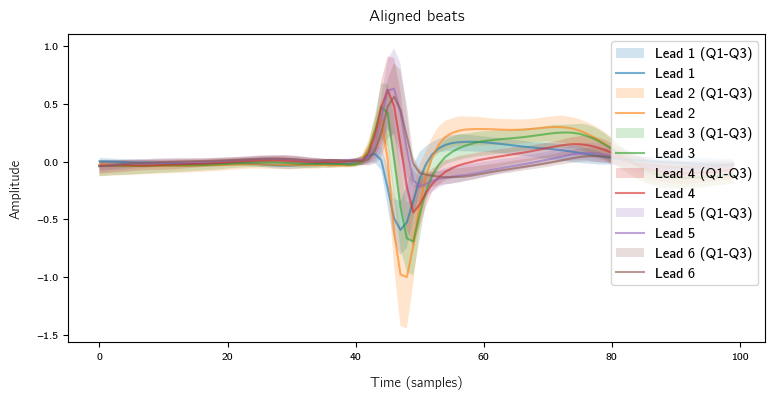

In [87]:
# Visualise aligned beats
fig, ax = plt.subplots(figsize=(9, 4))
for lead in range(all_x_beats.shape[1]):
    mean_beat = np.median(all_x_beats[:, lead, :], axis=0)
    q1_beat = np.quantile(all_x_beats[:, lead, :], 0.25, axis=0)
    q3_beat = np.quantile(all_x_beats[:, lead, :], 0.75, axis=0)
    ax.fill_between(np.arange(len(mean_beat)), q1_beat, q3_beat, alpha=0.2, label=f"Lead {lead+1} (Q1-Q3)")
    mean_beat = np.mean(all_x_beats, axis=0)[lead]
    ax.plot(mean_beat, label=f"Lead {lead+1}", alpha=0.6)

ax.set_title("Aligned beats")
ax.set_xlabel("Time (samples)")
ax.set_ylabel("Amplitude")
ax.legend()
plt.show()

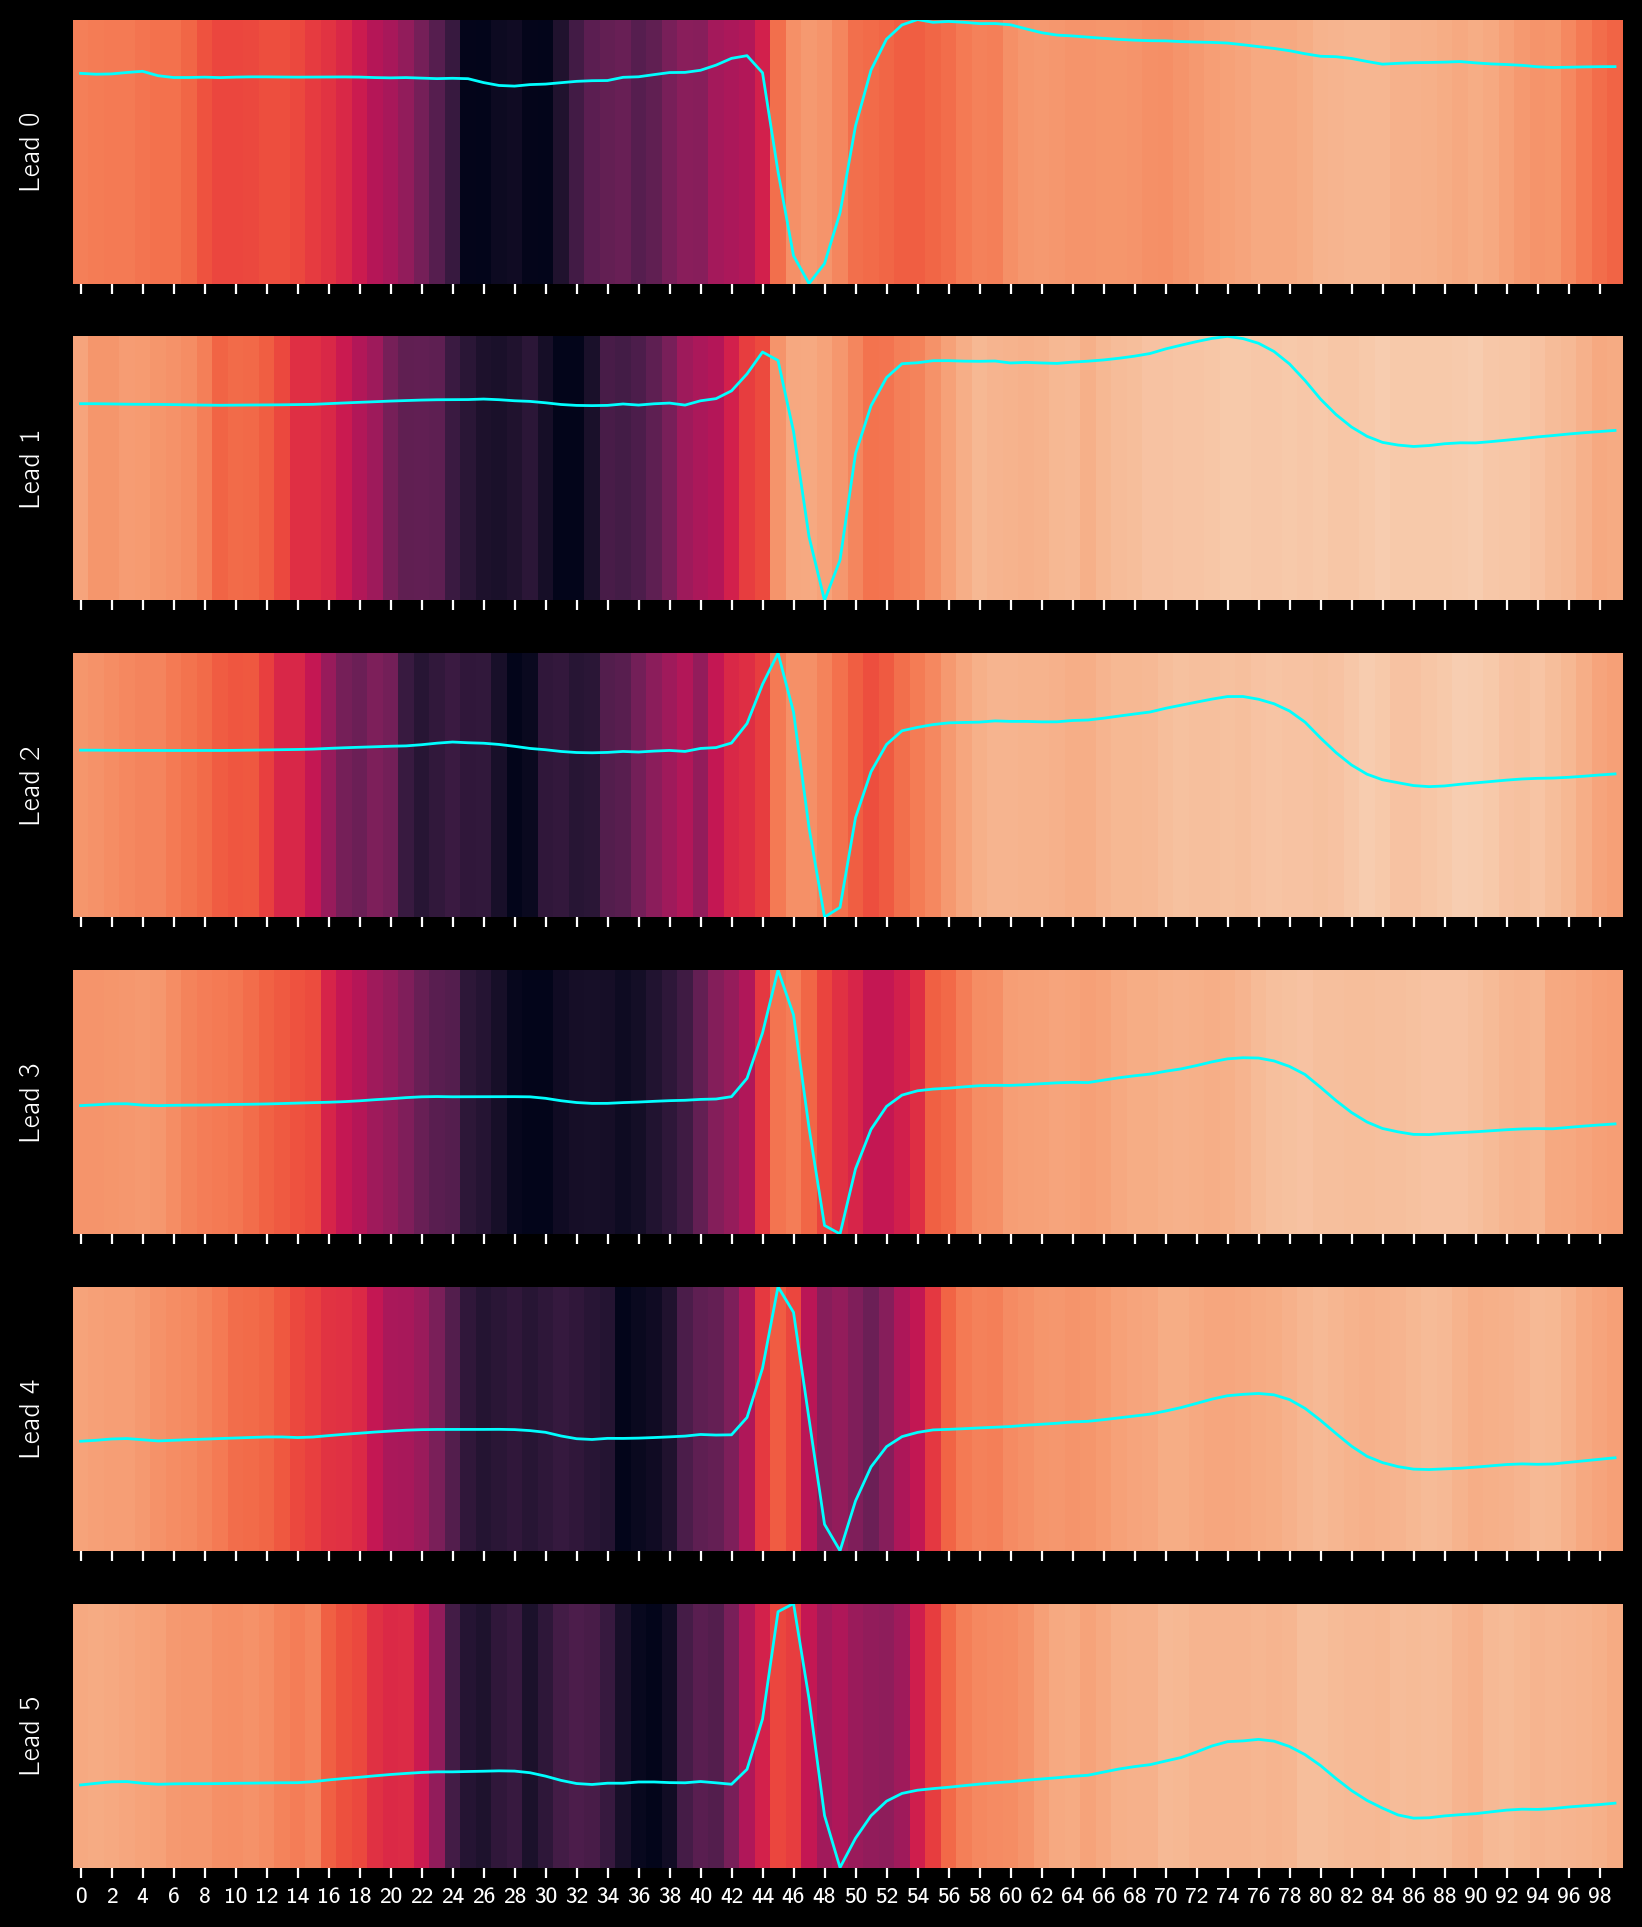

In [214]:
mean_sal = np.mean(all_sal_patches, axis=0)  # (L, target_len)
mean_ecg = np.mean(all_x_beats, axis=0)  # (L, target_len)

fig, axes = plt.subplots(mean_sal.shape[0], 1, figsize=(10, 2*mean_sal.shape[0]),
                         sharex=True, sharey=True)

t_pct = np.linspace(-35, 45, 1000)  # ms relative to R if fs=500 & window chosen above
for i, ax in enumerate(axes):
    sns.heatmap(mean_sal[i:i+1], ax=ax, cmap="rocket_r", cbar=False, vmin=0)
    ax.set_ylabel(f"Lead {i}")
    ax.set_yticks([])

    # Normalize all ECG signals to [0, 1]
    # Plot the ECG signal
    #mean_ecg_norm = (mean_ecg - mean_ecg.min()) / (mean_ecg.max() - mean_ecg.min())
    #ecg = mean_ecg_norm[i]
    ecg = all_x_beats[0][i]
    ecg_norm = (ecg - ecg.min()) / (ecg.max() - ecg.min())
    ax.plot(np.arange(len(ecg_norm)) + 0.5,
            1 - ecg_norm,
            color='cyan', linewidth=1)
#ax.set_xticklabels([f"{int(x)} ms" for x in t_pct[::32]], rotation=0)
#plt.title("Average saliency per heartbeat (aligned on R-peak)")
plt.show()

## PCA

In [88]:
model

SigLabV2(
  (encoder): CNNGRUEncoder(
    (cnn_encoder): Sequential(
      (0): InceptionBlock(
        (branch1): Sequential(
          (0): Conv1d(1, 32, kernel_size=(1,), stride=(1,))
          (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
        )
        (branch2): Sequential(
          (0): Conv1d(1, 1, kernel_size=(1,), stride=(1,))
          (1): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
          (3): Conv1d(1, 32, kernel_size=(5,), stride=(1,), padding=(2,))
          (4): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (5): ReLU()
        )
        (branch3): Sequential(
          (0): Conv1d(1, 1, kernel_size=(1,), stride=(1,))
          (1): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
          (3): Conv1d(1, 32, kernel_size=(11,), stride=(1,), padding=(5,)

In [168]:
model.encoder.cnn_encoder[-3]

InceptionBlock(
  (branch1): Sequential(
    (0): Conv1d(128, 32, kernel_size=(1,), stride=(1,))
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (branch2): Sequential(
    (0): Conv1d(128, 64, kernel_size=(1,), stride=(1,))
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv1d(64, 32, kernel_size=(5,), stride=(1,), padding=(2,))
    (4): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (branch3): Sequential(
    (0): Conv1d(128, 64, kernel_size=(1,), stride=(1,))
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv1d(64, 32, kernel_size=(11,), stride=(1,), padding=(5,))
    (4): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (branch4): Sequential(
    (0): MaxPool1d(kernel_size=3, stride

In [181]:
from sklearn.decomposition import PCA
from collections import defaultdict
from tqdm import tqdm

In [197]:
# ▸ 1. pick the layer you want to inspect
#     (example: model.encoder.cnn_post_layers[0] – an AdaptiveAvgPool1d)
# layer_to_hook = model.encoder.cnn_post_layers[2]   # <-- customise here
layer_to_hook = model.attention_blocks[-1]   # <-- customise here

feature_store = []

def hook(module, inp, out):
    """
    Capture the tensor you care about.
    Expecting shape (B*N, D).
    """
    feature_store.append(out.detach().cpu())

hook_handle = layer_to_hook.register_forward_hook(hook)

# ▸ 2. run the model on a few batches and collect features
lead_labels  = []        # one lead label per feature vector
lead_vectors = []        # flattened feature vectors

dataloader = DataLoader(dataset,
                        batch_size=32,  
                        shuffle=False) 

model.eval()
#n_batches = 50           # feel free to increase
with torch.no_grad():
    for i, batch in enumerate(tqdm(dataloader)):
        #if i >= n_batches: break
        x, _ = batch         # or whatever your DataLoader yields
        x = x.to(device)     # shape (B, C, 1000)
        _, *_ = model(x)         # populates feature_store

        feat   = feature_store.pop()  # (B*N, D)
        # Reshape to (B, N, D) if needed
        feat   = feat.reshape(x.size(0), x.size(1), -1)  # (B, N, D)

        B = feat.shape[0]
        for b in range(B):  # Iterate over batch
            for lead in range(x.size(1)):            # Iterate over leads
                lead_vectors.append(feat[b, lead].numpy())         # Append the feature vector
                lead_labels .append(lead)            # 0…5

hook_handle.remove()

lead_vectors = np.vstack(lead_vectors)   # (samples, C_feat)
lead_labels  = np.array(lead_labels)     # (samples,)

100%|██████████| 69/69 [00:03<00:00, 20.09it/s]


In [183]:
lead_vectors.shape, lead_labels.shape

((13098, 128), (13098,))

In [198]:
# ▸ 3. PCA → 2-D
pca  = PCA(n_components=2, random_state=0)
proj = pca.fit_transform(lead_vectors)   # (samples, 2)

In [195]:
proj = pca.transform(lead_vectors)

In [114]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.interpolate import interp1d                    # for smooth colour wheel

def pretty_pca_plot(xy, labels, title="Latent-space bouquet",
                    point_size=18, alpha_back=0.10, alpha_front=0.75,
                    pad=0.1):
    """
    xy       – (N,2) or (N,3) array of points
    labels   – (N,) array with integer lead IDs 0…5
    """
    # ------------------------------------------------------------
    # Set up a dark, minimal aesthetic
    # ------------------------------------------------------------
    mpl.rcParams.update({
        "figure.facecolor":   "#111216",
        "axes.facecolor":     "#111216",
        "axes.edgecolor":     "#888888",
        "axes.labelcolor":    "#CCCCCC",
        "xtick.color":        "#888888",
        "ytick.color":        "#888888",
        "axes.grid":          False,
        "font.size":          12,
    })
    plt.style.use("dark_background")

    # ------------------------------------------------------------
    # Build a smooth 6-colour circular palette
    # ------------------------------------------------------------
    base = np.array([[0.24,0.63,1.0],    # blue
                     [0.19,0.83,0.94],   # teal
                     [0.27,0.89,0.52],   # green
                     [1.00,0.78,0.28],   # orange
                     [1.00,0.48,0.32],   # coral
                     [0.89,0.33,0.65]])  # magenta
    # tile + interpolate so colours wrap around smoothly
    base = np.vstack([base, base[0,None]])
    wheel = interp1d(np.linspace(0,6,7), base, axis=0)(np.arange(6))

    # ------------------------------------------------------------
    # Two-layer scatter for subtle glow
    # ------------------------------------------------------------
    fig, ax = plt.subplots(figsize=(7,6), dpi=400)

    # Convert z to size
    z = np.ones(xy.shape[0])
    if xy.shape[1] == 3:
        z = xy[:,2]
        z = (z - z.min()) / (z.max() - z.min())
        z = z * 100 + 10
        z = z.astype(int)

    for k in range(6):
        idx = labels == k
        point_size *= z[idx]
        # back layer – large, low-alpha halo
        ax.scatter(xy[idx,0], xy[idx,1], s=point_size*2,
                   color=wheel[k], alpha=alpha_back, linewidths=0)
        # front layer – crisp centre
        ax.scatter(xy[idx,0], xy[idx,1], s=point_size,
                   color=wheel[k], alpha=alpha_front, linewidths=0)

    # ------------------------------------------------------------
    # Finishing touches
    # ------------------------------------------------------------
    ax.set_title(title, color="#E0E0E0", pad=12, weight="semibold")
    ax.set_xlabel("PC 1"); ax.set_ylabel("PC 2")
    ax.set_aspect("equal", adjustable="datalim")

    ax.set_xlim(xy[:,0].min()-0.5, xy[:,0].max()+0.5)
    ax.set_ylim(xy[:,1].min()-0.5, xy[:,1].max()+0.5)

    # dark legend
    handles = [mpl.lines.Line2D([], [], color=wheel[k], marker="o", linestyle="",
                                markersize=6) for k in range(6)]
    ax.legend(handles,
              [f"Lead {k+1}" for k in range(6)],
              frameon=False, loc="lower right", labelcolor="#DDDDDD",
              fontsize=8, markerscale=0.8, handlelength=1.2)

    xmin, xmax = xy[:,0].min(), xy[:,0].max()
    ymin, ymax = xy[:,1].min(), xy[:,1].max()

    xrange = xmax - xmin
    yrange = ymax - ymin

    ax.set_xlim(xmin - pad * xrange, xmax + pad * xrange)
    ax.set_ylim(ymin - pad * yrange, ymax + pad * yrange)

    plt.tight_layout()
    plt.show()


Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


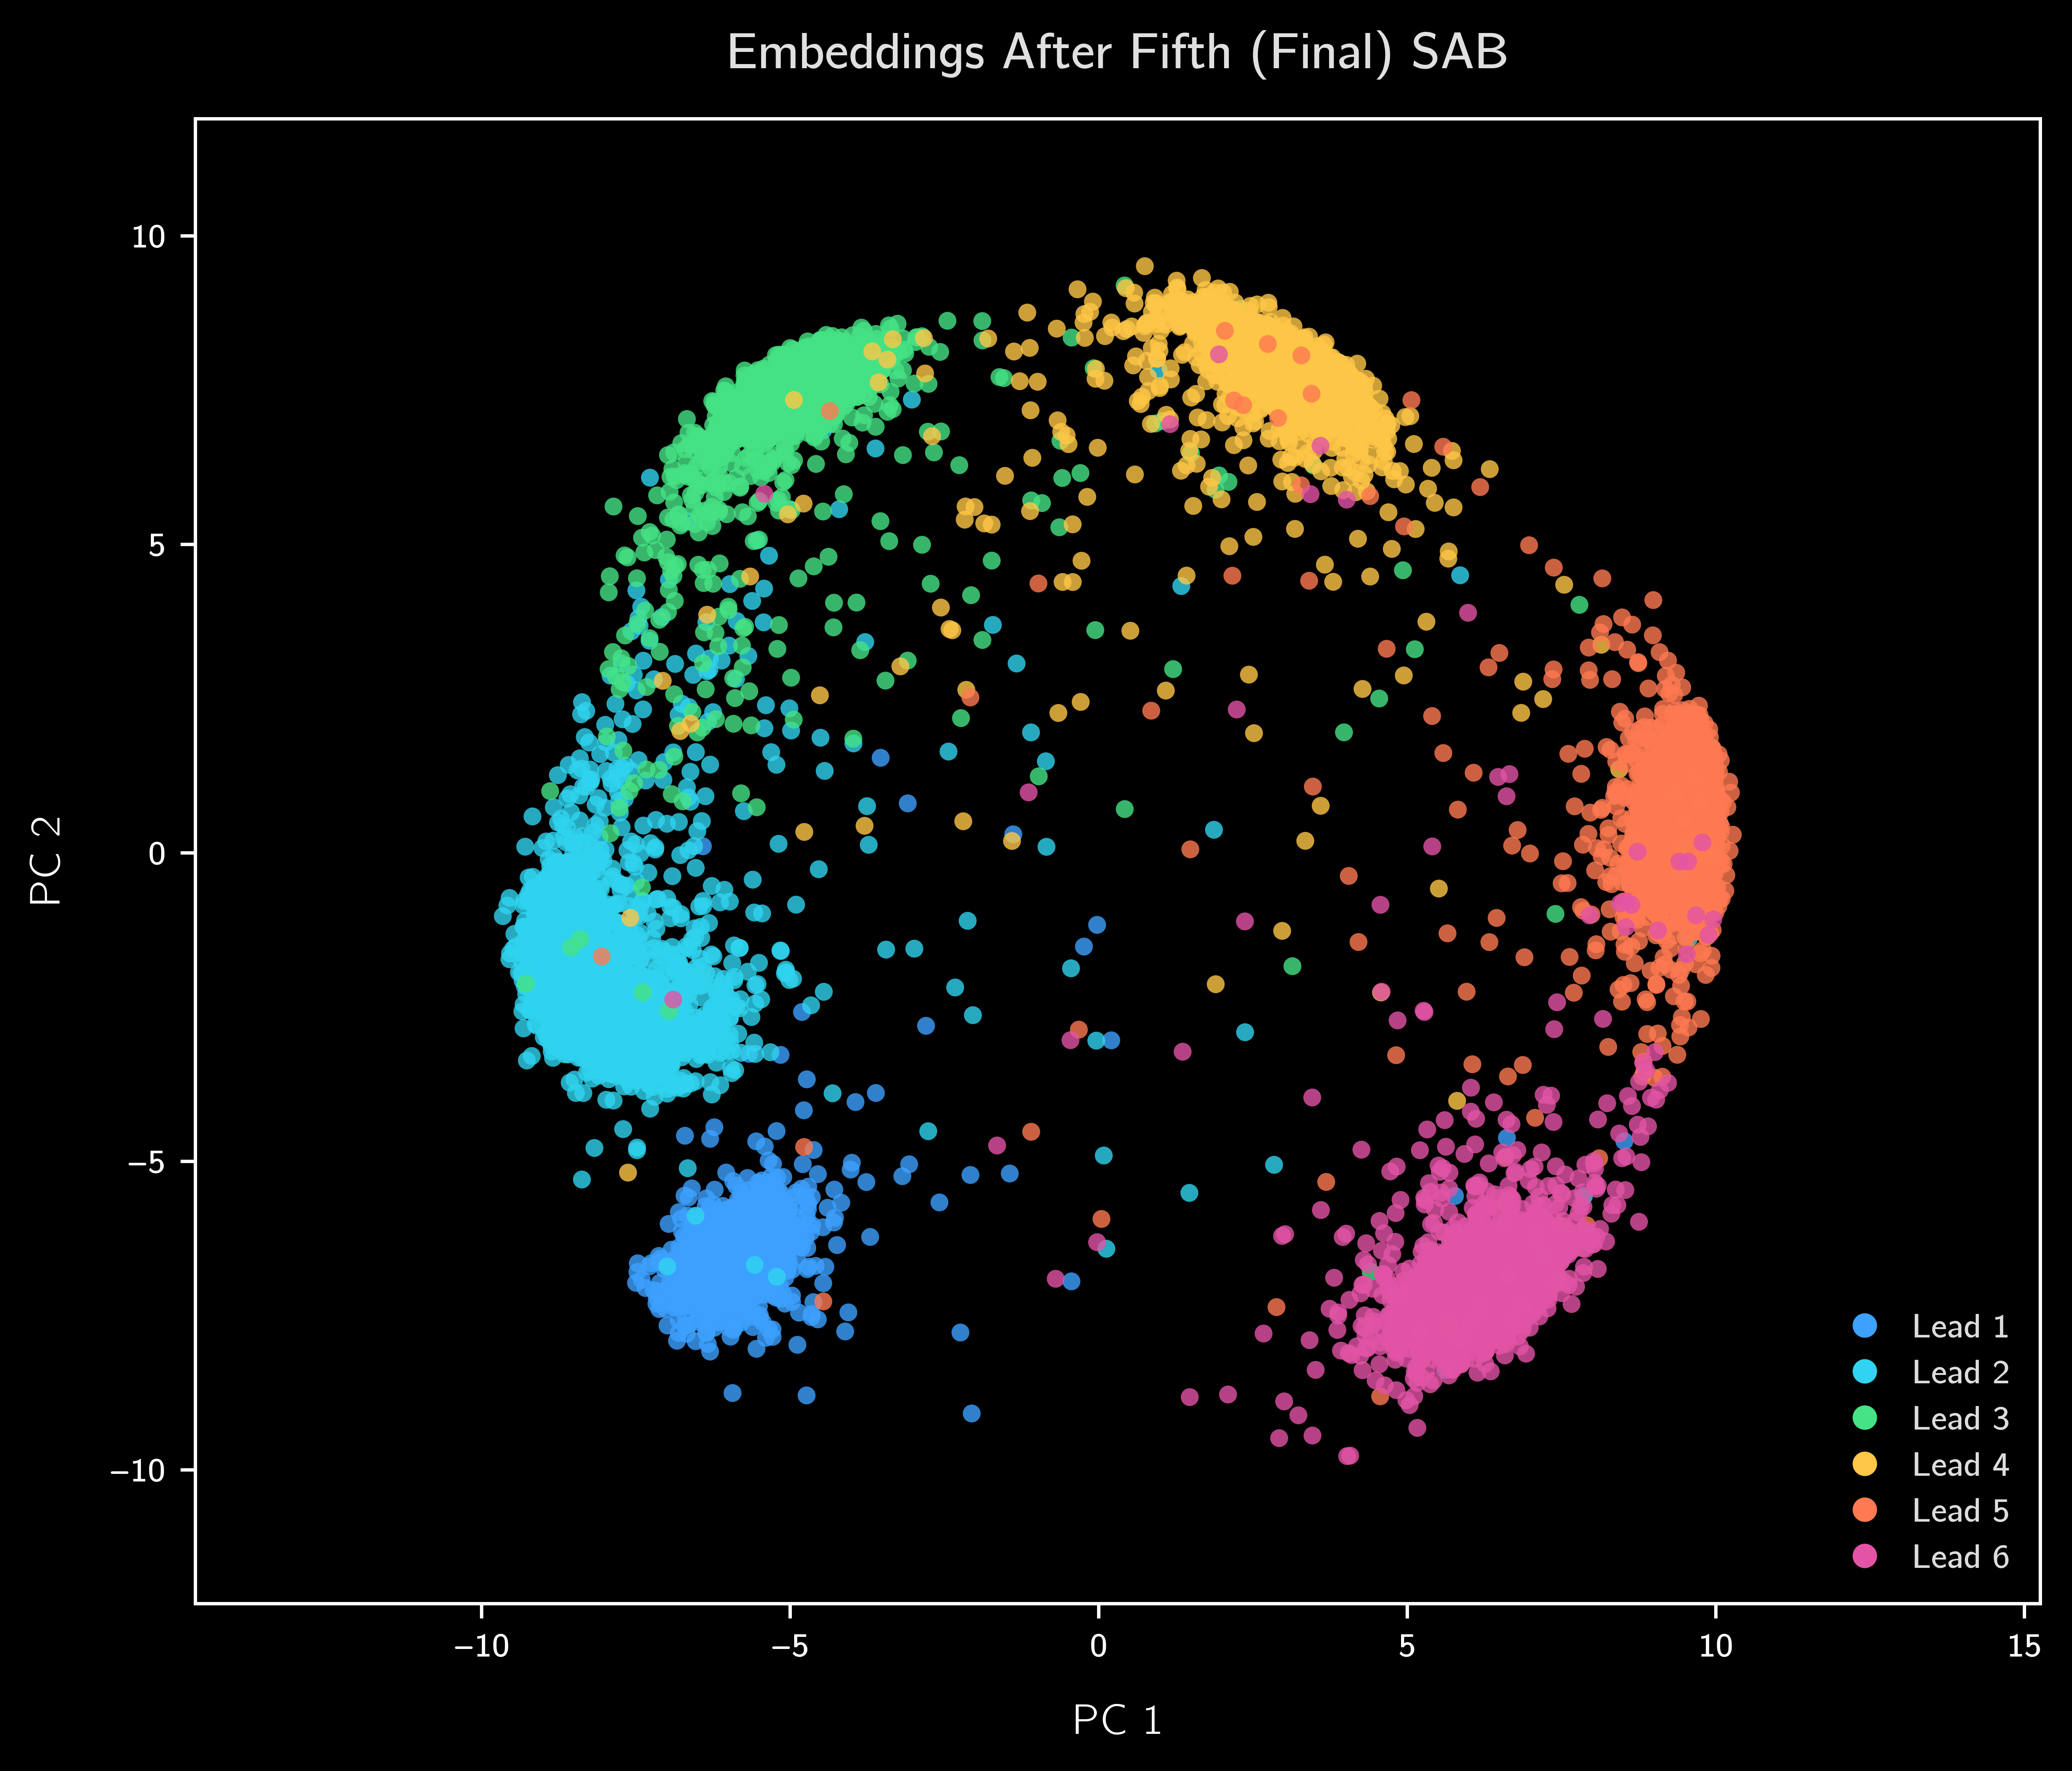

In [199]:
%config InlineBackend.figure_format = 'retina'  # for high-res plots
plt.ion()
pretty_pca_plot(proj, lead_labels, title="Embeddings After Fifth (Final) SAB", pad=0.25,
                alpha_front=0.8, alpha_back=0)

# Visualising Activations

In [107]:
# ----‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑
# storage for intermediates
# ----‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑
activation_trace = {}        # {layer_name: tensor[B, T]}
def make_hook(name):
    def _hook(module, inputs, output):
        # detach → no autograd, move to CPU for easy inspection
        activation_trace[name] = output.detach().cpu()
    return _hook

def gru_hook(module, inputs, output):
    out_seq, h_n = output
    activation_trace["gru"] = out_seq.detach().cpu()

def gru_attn_hook(module, inputs, output):
    attn_scores = output.squeeze(-1)
    alpha = torch.nn.functional.softmax(attn_scores, dim=1)
    activation_trace["attn"] = alpha.detach().cpu()

def encoder_hook(module, inputs, output):
    activation_trace["encoder"] = output.detach().cpu()

def inception_hook(module, inputs, output):
    activation_trace["inception"] = output.detach().cpu()

# ----‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑
# attach to the post-gru activations
# ----‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑
hook_handles = []
hook_handles.append(model.encoder.gru.register_forward_hook(gru_hook))
hook_handles.append(model.encoder.register_forward_hook(encoder_hook))
hook_handles.append(model.encoder.attn_vec.register_forward_hook(gru_attn_hook))
hook_handles.append(model.encoder.cnn_encoder.register_forward_hook(inception_hook))

# ----‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑
# attach to every InceptionBlock
# ----‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑
#hook_handles.append(model.encoder.cnn_encoder[0].branch1.register_forward_hook(make_hook("branch1")))
#hook_handles.append(model.encoder.cnn_encoder[0].branch2.register_forward_hook(make_hook("branch2")))
#hook_handles.append(model.encoder.cnn_encoder[0].branch3.register_forward_hook(make_hook("branch3")))
#hook_handles.append(model.encoder.cnn_encoder[0].branch4.register_forward_hook(make_hook("branch4")))


In [30]:
np.where(meta["diagnostic_superclass"].apply(lambda x: "NORM" in x))[0]

array([   1,   12,   15,   16,   17,   18,   19,   20,   24,   28,   32,
         37,   39,   40,   41,   42,   44,   46,   47,   50,   54,   56,
         58,   59,   60,   61,   62,   63,   66,   67,   68,   70,   72,
         73,   74,   76,   85,   89,   90,   93,   96,   97,  103,  104,
        105,  106,  107,  108,  113,  115,  116,  119,  120,  121,  123,
        124,  125,  126,  127,  128,  129,  131,  132,  133,  135,  136,
        137,  141,  143,  145,  147,  148,  150,  152,  153,  156,  159,
        161,  162,  163,  165,  167,  174,  175,  176,  184,  186,  188,
        191,  193,  194,  197,  199,  200,  201,  202,  203,  204,  207,
        209,  212,  213,  218,  220,  221,  222,  223,  224,  229,  232,
        233,  245,  248,  249,  251,  254,  256,  259,  261,  262,  264,
        266,  268,  269,  270,  271,  273,  275,  276,  277,  279,  280,
        281,  285,  287,  288,  289,  290,  291,  292,  293,  298,  299,
        300,  301,  302,  305,  306,  308,  313,  3

In [82]:
#sample = wrong[-1][0]
#sample = wrong[0][0]
#sample = pacemaker_idx[0]
sample = 1
model.eval()                 # or model.train() if you want dropout etc.
with torch.no_grad():        # no need for gradients when just observing
    x = val_data[sample].unsqueeze(0).to(device)
    _ = model(x)             # forward pass populates logit_trace

# Unregister the hooks
for handle in hook_handles:
    handle.remove()

In [83]:
activation_trace['inception'].shape
activation_trace['gru'].shape

torch.Size([6, 250, 128])

In [84]:
lead = 1
#gru_delta = activation_trace['gru'][lead][1:] - activation_trace['gru'][lead][:-1]
#gru_curve = gru_delta.abs().sum(-1).cpu().numpy()
gru_curve = activation_trace['gru'][lead].sum(-1).abs().cpu().numpy()
gru_attn_curve = activation_trace['attn'][lead].cpu().numpy()
weighted_gru_curve = activation_trace['gru'][lead] * activation_trace['attn'][lead].unsqueeze(-1)
weighted_gru_curve = weighted_gru_curve.sum(-1).cpu().numpy()
#branch1_curve = activation_trace['branch1'][lead].cpu().numpy()
#branch2_curve = activation_trace['branch2'][lead].sum(0).cpu().numpy()
#branch3_curve = activation_trace['branch3'][lead].sum(0).cpu().numpy()
#branch5_curve = activation_trace['branch4'][lead].sum(0).cpu().numpy()
cnn_curve = activation_trace['inception'][lead].mean(0).abs().cpu().numpy()

In [85]:
gru_curve.shape, weighted_gru_curve.shape, cnn_curve.shape

((250,), (250,), (250,))

In [74]:
gru_attn_curve.shape

(250,)

In [86]:
# Unpool to get activations to match the original input shape
T = 1000
#L_c = branch1_curve.shape[0]
L_c = cnn_curve.shape[0]
T_g = gru_curve.shape[0]
x_inp = np.linspace(0, 1, T)
#branch1_curve = np.interp(x_inp, np.linspace(0, 1, L_c), branch1_curve)
#branch2_curve = np.interp(x_inp, np.linspace(0, 1, L_c), branch2_curve)
#branch3_curve = np.interp(x_inp, np.linspace(0, 1, L_c), branch3_curve)
#branch5_curve = np.interp(x_inp, np.linspace(0, 1, L_c), branch5_curve)
cnn_curve = np.interp(x_inp, np.linspace(0, 1, L_c), cnn_curve)
gru_curve = np.interp(x_inp, np.linspace(0, 1, T_g), gru_curve)
gru_attn_curve = np.interp(x_inp, np.linspace(0, 1, gru_attn_curve.shape[0]), gru_attn_curve)
weighted_gru_curve = np.interp(x_inp, np.linspace(0, 1, T_g), weighted_gru_curve)

#branch1_curve.shape, branch2_curve.shape, branch3_curve.shape, branch5_curve.shape, gru_curve.shape, gru_attn_curve.shape

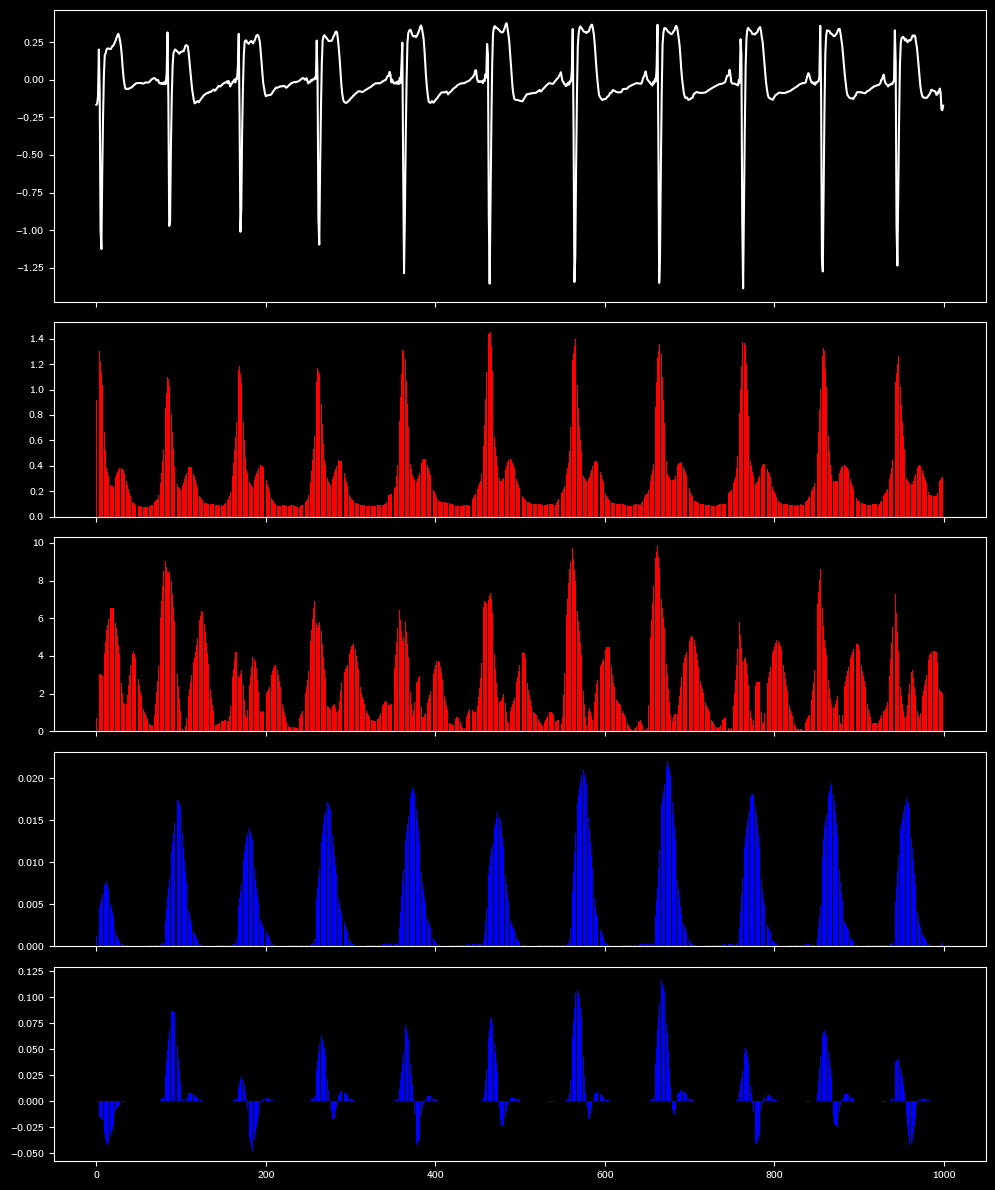

In [87]:
time_window = (0, 1000)
# Visualise the activations of the gru_last layer
# Set background color to black
plt.style.use('dark_background')
fig, axs = plt.subplots(5, 1, figsize=(10, 12), sharex=True, gridspec_kw={'height_ratios':[3,2,2,2, 2]})
axs[0].plot(val_data[sample][lead].cpu().numpy()[time_window[0]:time_window[1]], color='white', label='ECG')
axs[1].bar(np.arange(*time_window), cnn_curve[time_window[0]:time_window[1]], color='red', label='Branch 1')
#axs[1].bar(np.arange(*time_window), branch1_curve[time_window[0]:time_window[1]], color='red', label='Branch 1')
#axs[2].bar(np.arange(*time_window), branch2_curve[time_window[0]:time_window[1]], color='blue', label='Branch 2')
#axs[3].bar(np.arange(*time_window), branch3_curve[time_window[0]:time_window[1]], color='green', label='Branch 3')
#axs[4].bar(np.arange(*time_window), branch5_curve[time_window[0]:time_window[1]], color='orange', label='Branch 5')
axs[2].bar(np.arange(*time_window), gru_curve[time_window[0]:time_window[1]], color='red', label='GRU')
axs[3].bar(np.arange(*time_window), gru_attn_curve[time_window[0]:time_window[1]], color='blue', label='Attention')
axs[4].bar(np.arange(*time_window), weighted_gru_curve[time_window[0]:time_window[1]], color='blue', label='Attention')

plt.tight_layout()
plt.show()

In [90]:
predictions[sample], targets[sample]

(array([0, 1, 2, 3, 4, 5]), array([0., 1., 2., 3., 4., 5.]))

shape: torch.Size([500, 128])


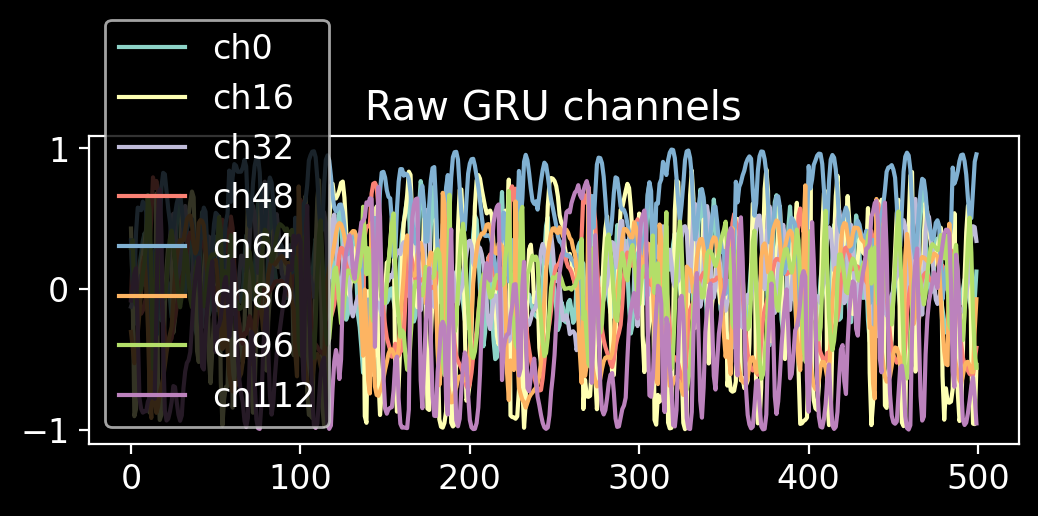

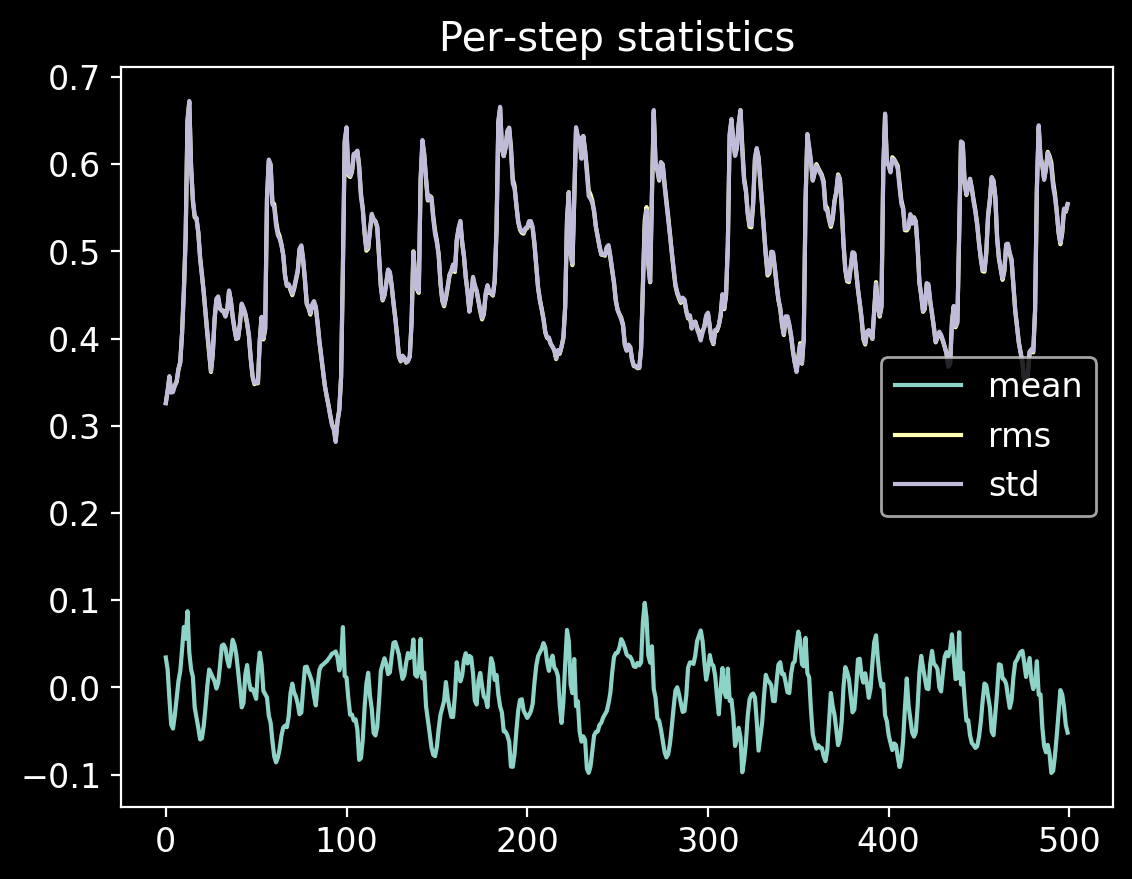

In [89]:
seq = activation_trace["gru"][0]           # (T=250, H=128) on CPU
print("shape:", seq.shape)

# (1) plot a handful of raw channels
plt.figure(figsize=(6,2))
for ch in range(0, 128, 16):
    plt.plot(seq[:, ch], label=f"ch{ch}")
plt.legend(); plt.title("Raw GRU channels"); plt.show()

# (2) signed mean, std and L2‑norm per step
signed = seq.mean(-1)
l2     = seq.pow(2).mean(-1).sqrt()
std    = seq.std(-1)

plt.plot(signed, label="mean")
plt.plot(l2,     label="rms")
plt.plot(std,    label="std")
plt.legend(); plt.title("Per‑step statistics"); plt.show()


Saliency

In [68]:
time_window = (0, 1000)
sample = 0
lead_indices = [0, 1, 2, 3, 4, 5]  # define the leads you want to visualize

IndexError: too many indices for tensor of dimension 0

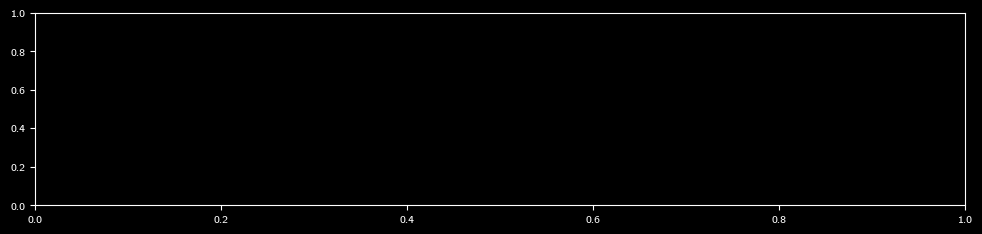

In [88]:
x = val_data[sample].unsqueeze(0).to(device)  # shape [1, L, T]
x.requires_grad = True

model.train()  # Put into train mode to get gradients
output = model(x)[0][0]  # [num_leads, num_classes]

num_leads = len(lead_indices)
fig, axes = plt.subplots(num_leads, 1, figsize=(12, 2.5 * num_leads), sharex=True,
                         gridspec_kw={'hspace': 0.15})

for i, lead in enumerate(lead_indices):
    lead_output = output[lead]
    target_idx = lead_output.argmax()
    target = lead_output[target_idx]

    model.zero_grad()
    x.grad = None
    target.backward(retain_graph=True)

    saliency = x.grad.data.abs()[0, lead].cpu().numpy()
    saliency = saliency / saliency.max()
    saliency = saliency[time_window[0]:time_window[1]]
    saliency_smooth = gaussian_filter1d(saliency, sigma=3)
    saliency_2d = saliency_smooth[np.newaxis, :]

    ecg = x[0, lead].cpu().detach().numpy()
    ecg = ecg[time_window[0]:time_window[1]]
    ecg_scaled = (ecg - ecg.min()) / (ecg.max() - ecg.min())

    ax = axes[i] if num_leads > 1 else axes
    im = ax.imshow(saliency_2d,
                   cmap='inferno',
                   aspect='auto',
                   extent=[0, len(ecg), 0, 1],
                   norm=plt.Normalize(vmin=0.01, vmax=saliency.max()))

    ax.plot(np.arange(len(ecg)), ecg_scaled, color='cyan', linewidth=1.5, linestyle='-', alpha=0.8)

    # Minimal labeling
    ax.set_yticks([])
    ax.set_ylabel(f"Lead {lead}", color='white', rotation=0, labelpad=30, fontsize=10, va='center')
    ax.set_facecolor('black')
    ax.tick_params(colors='white')
    ax.axhline(y=0, color='white', linewidth=2, alpha=0.8)

    # Clean borders
    for spine in ax.spines.values():
        spine.set_visible(False)

    # Hide x-ticks on all but last subplot
    if i < num_leads - 1:
        ax.set_xticks([])
    else:
        ax.set_xlabel('Time', color='white')

# Add a single colorbar to the side
cbar = fig.colorbar(im, ax=axes, orientation='vertical', fraction=0.02, pad=0.01)
cbar.set_label('Saliency', color='white')
cbar.ax.yaxis.set_tick_params(color='white')
plt.setp(cbar.ax.get_yticklabels(), color='white')

# Title for the whole figure
fig.suptitle(f'Saliency maps for sample {sample}', color='white', fontsize=18)
fig.patch.set_facecolor('black')

#plt.tight_layout(rect=[0, 0, 0.97, 0.90])
plt.subplots_adjust(left=0.1, right=0.85, top=0.95, bottom=0.1)
plt.show()